# Learning Option Deltas

## Package management

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
sns.set_theme()

In [4]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import fsolve

In [5]:
from scipy.stats import norm as st_norm
from scipy.stats import t as st_t

In [6]:
import scipy.interpolate as scint

In [7]:
from itertools import product

In [8]:
import math

In [9]:
import time

In [10]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

## Black model

### Normal Distribution Functions

In [11]:
def npdf(x, mu=0, sigma=1):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (np.sqrt(2 * math.pi) * sigma)

In [12]:
def ncdf(x, mu=0, sigma=1):
    return 0.5 * math.erfc((mu - x) / (np.sqrt(2) * sigma))

### Pricing Functions

In [13]:
def d12(pm, x, K, t, sigma):
    if t <= 0:
        if x == K:
            return 0.
        else:
            return np.sign(np.log(x / K)) * np.inf
    else:
        return (np.log(x / K) + pm * 0.5 * (sigma ** 2) * t) / (sigma * np.sqrt(t))

In [14]:
def pxf(phi, F, K, t, vol, discf=1):
    return discf * (phi * F * ncdf(phi * d12(+1, F, K, t, vol)) -
                    phi * K * ncdf(phi * d12(-1, F, K, t, vol)))

### Complete Function with Greeks

In [15]:
def black_model(phi, F, K, t, vol, F_t1, dt=1/252, discf=1):
    bump = 0.001
    del_chg = 2 * F * bump
    vol_chg = 2 * vol * bump
    F_up = F * (1 + bump)
    F_do = F * (1 - bump)
    F_up2 = F * (1 + 2 * bump)
    F_do2 = F * (1 - 2 * bump)
    vol_up = vol * (1 + bump)
    vol_do = vol * (1 - bump)
    eff_var = (vol ** 2) * t
    if (t - dt) > 0:
        vol_t1 = vol
        discf_t1 = discf ** ((t - dt) / t)
    else:
        vol_t1 = 0
        discf_t1 = 1
    premium = pxf(phi, F, K, t, vol, discf)
    intrinsic = max(phi * (F - K), 0)
    time_value = premium - intrinsic
    prem_up = pxf(phi, F_up, K, t, vol, discf)
    prem_do = pxf(phi, F_do, K, t, vol, discf)
    prem_up2 = pxf(phi, F_up2, K, t, vol, discf)
    prem_do2 = pxf(phi, F_do2, K, t, vol, discf)
    prem_vol_up = pxf(phi, F, K, t, vol_up, discf)
    prem_vol_do = pxf(phi, F, K, t, vol_do, discf)
    prem_t1 = pxf(phi, F_t1, K, t - dt, vol_t1, discf_t1)
    delta = (prem_up - prem_do) / del_chg
    delta_up = (prem_up2 - premium) / del_chg
    delta_do = (premium - prem_do2) / del_chg
    gamma = (delta_up - delta_do) / del_chg
    gamma_1pc = gamma * F * 0.01
    vega = (prem_vol_up - prem_vol_do) / vol_chg
    vega_1pc = vega * 0.01
    theta = prem_t1 - premium
    return [premium, intrinsic, time_value, delta, gamma, gamma_1pc, vega, vega_1pc, theta]

In [16]:
black_model(1, 110, 100, 1, 0.20, 100)

[14.292010941409885,
 10,
 4.292010941409885,
 0.7178774685507832,
 0.015356929554420513,
 0.016892622509862565,
 37.163840375988855,
 0.37163840375988855,
 -6.342211385852188]

### Implied Volatility

In [17]:
def implied_vol(phi, F, K, t, vol0, premium, discf=1):
    def f_root(x):
        return pxf(phi, F, K, t, x, discf) - premium
    root = fsolve(f_root, vol0)
    return root[0]

In [18]:
implied_vol(1, 110, 100, 1, 0.10, 14.292)

0.1999997055898866

In [19]:
implied_vol(1, 100, 100, 1, 0.10, 6)

0.15053972419965975

In [20]:
black_model(1, 100, 100, 1, 0.15, 100)

[5.978528810578958,
 0,
 5.978528810578958,
 0.5298919810235958,
 0.02652109568597183,
 0.02652109568597183,
 39.782183123691084,
 0.39782183123691084,
 -0.011851770954592666]

## Sigmoid functions

In [21]:
nerfc = np.vectorize(math.erfc)
def delta_call(x):
    return 0.5 * nerfc(x)
def delta_put(x):
    return 0.5 * nerfc(x) - 1

In [22]:
rngx = np.linspace(-10,+10,2000+1)

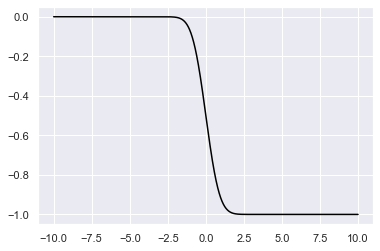

In [23]:
plt.plot(rngx, delta_put(rngx), color='black');

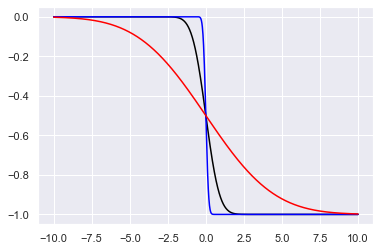

In [24]:
plt.plot(rngx, delta_put(rngx), color='black');
plt.plot(rngx, delta_put(5 * rngx), color='blue');
plt.plot(rngx, delta_put(0.2 * rngx), color='red');

## Monte Carlo

### Distributions

#### Normal

In [21]:
seed = 20

In [22]:
st_norm.rvs(size=10, random_state=seed)

array([ 0.88389311,  0.19586502,  0.35753652, -2.34326191, -1.08483259,
        0.55969629,  0.93946935, -0.97848104,  0.50309684,  0.40641447])

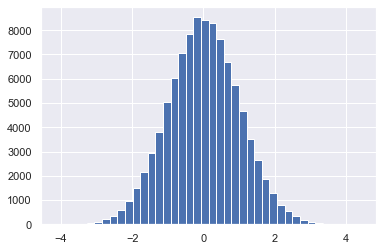

In [23]:
pd.Series(st_norm.rvs(size=100000, random_state=seed)).hist(bins=40);

#### Student's T

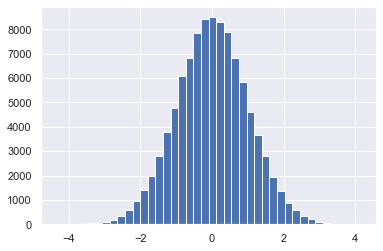

In [24]:
pd.Series(st_t.rvs(df=10**9, size=100000, random_state=seed)).hist(bins=40);

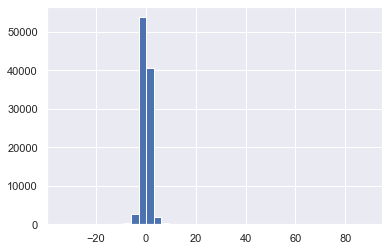

In [25]:
pd.Series(st_t.rvs(df=3, size=100000, random_state=seed)).hist(bins=40);

### Monte Carlo Path

In [26]:
def mc_path(s, drift, vol, t, rnds):
    steps = len(rnds)
    dt = t / steps
    log_ret = ((drift - 0.5 * (vol ** 2)) * dt +
        vol * np.sqrt(dt) * rnds)
    return s * np.exp(np.cumsum(np.insert(log_ret, 0, 0)))

In [27]:
def log_ret(path):
    return np.log(path[1:] / path[:-1])

In [28]:
def realized_vol(s_path, ann_fac=np.sqrt(252)):
    return np.std(log_ret(s_path)) * ann_fac

In [29]:
s0 = 100.
drift0 = 0.
vol0 = 0.16
t0 = 1.
steps0 = 252

In [30]:
df1 = pd.DataFrame({
    'Normal(0, 16%)': mc_path(s0, drift0, vol0, t0, st_t.rvs(df=10**9, size=steps0, random_state=seed)),
    'Normal(10%, 16%)': mc_path(s0, drift0 + 0.10, vol0, t0, st_t.rvs(df=10**9, size=steps0, random_state=seed)),
    'Normal(0, 32%)': mc_path(s0, drift0, vol0 * 2, t0, st_t.rvs(df=10**9, size=steps0, random_state=seed)),
    'StT(3)(0, 16%/Sqrt(3))': mc_path(s0, drift0, vol0 / np.sqrt(3), t0, st_t.rvs(df=3, size=steps0, random_state=seed))
}, index=np.linspace(0, t0, steps0 + 1))

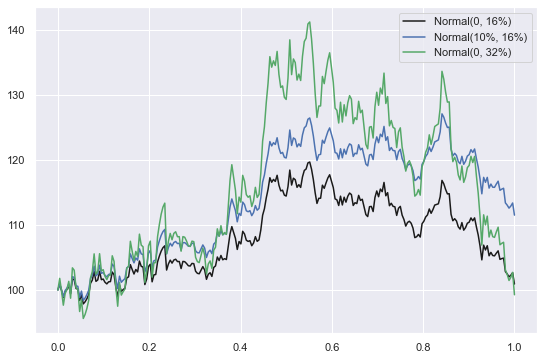

In [31]:
df1.iloc[:, :3].plot(figsize=(9, 6), color=['k', 'b', 'g']);

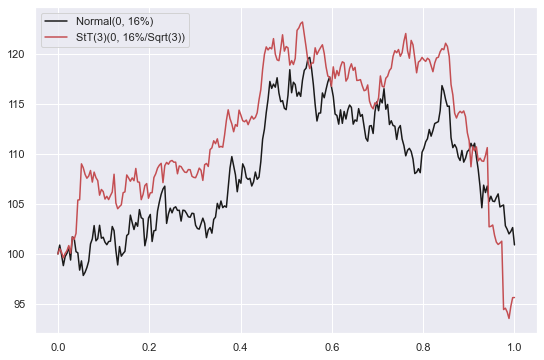

In [32]:
df1.iloc[:, [0, 3]].plot(figsize=(9, 6), color=['k', 'r']);

In [33]:
df2 = pd.DataFrame({
    'StT(10)(0, 16%/Sqrt(10/8))': mc_path(s0, drift0, vol0 / np.sqrt(10/8), t0, st_t.rvs(df=10, size=steps0, random_state=seed)),
    'StT(5)(0, 16%/Sqrt(5/3))': mc_path(s0, drift0, vol0 / np.sqrt(5/3), t0, st_t.rvs(df=5, size=steps0, random_state=seed)),
    'StT(3)(0, 16%/Sqrt(3))': mc_path(s0, drift0, vol0 / np.sqrt(3), t0, st_t.rvs(df=3, size=steps0, random_state=seed))
}, index=np.linspace(0, t0, steps0 + 1))

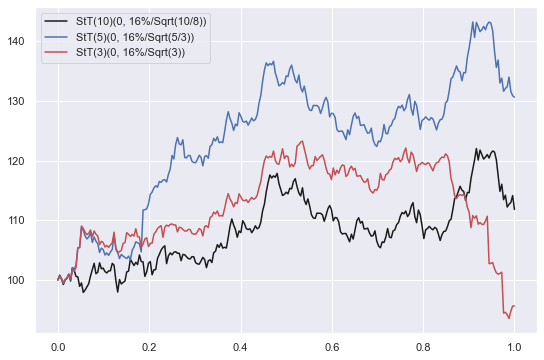

In [34]:
df2.plot(figsize=(9, 6), color=['k', 'b', 'r']);

### Student's T (3) - no convergence

In [76]:
df3 = pd.DataFrame({
    'StT(10)(0, 16%/Sqrt(10/8))': 
    mc_path(s0, drift0, vol0 / np.sqrt(10/8), t0 * 1000, st_t.rvs(df=10, size=steps0 * 1000, random_state=seed)),
    'StT(5)(0, 16%/Sqrt(5/3))':
    mc_path(s0, drift0, vol0 / np.sqrt(5/3), t0 * 1000, st_t.rvs(df=5, size=steps0 * 1000, random_state=seed)),
    'StT(3)(0, 16%/Sqrt(3))':
    mc_path(s0, drift0, vol0 / np.sqrt(3), t0 * 1000, st_t.rvs(df=3, size=steps0 * 1000, random_state=seed))
})

In [77]:
df3d = df3.diff()

In [78]:
df3d.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,"StT(10)(0, 16%/Sqrt(10/8))","StT(5)(0, 16%/Sqrt(5/3))","StT(3)(0, 16%/Sqrt(3))"
count,252000.000000,2.520000e+05,252000.000000
mean,-0.000397,-3.968240e-04,0.853289
std,0.256183,1.985283e-01,367.669697
min,-6.739227,-1.068745e+01,-22214.337400
1%,-0.856909,-6.167795e-01,-694.595509
5%,-0.292462,-1.907612e-01,-107.660868
10%,-0.131976,-8.624112e-02,-42.942092
25%,-0.007683,-5.928320e-03,-7.343259
50%,-0.000004,-2.665785e-07,-0.002592
75%,0.007343,5.417934e-03,7.351848


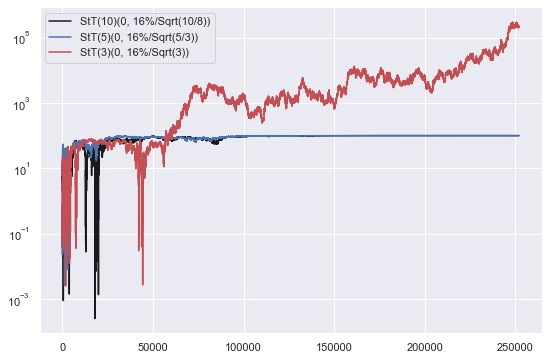

In [38]:
np.abs(df3d.cumsum()).plot(logy=True, figsize=(9, 6), color=['k', 'b', 'r']);

## Delta Hedging

### Times to maturity

In [39]:
def ttm(t, steps):
    return np.linspace(t, 0, steps + 1)

In [40]:
ttm(1, 10)

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

### Option data over path

In [41]:
def black_path(phi, Fs, K, ttms, vol):
    n = len(ttms)
    black_data = pd.DataFrame([
        black_model(phi, Fs[j], K, ttms[j], vol, Fs[j])
        for j in range(n)], index=np.flip(ttms),
        columns=['premium', 'intrinsic', 'time_value', 'delta', 'gamma', 'gamma_1pc', 'vega', 'vega_1pc', 'theta'])
    black_data['F'] = Fs
    return black_data

In [42]:
path1 = mc_path(s0, drift0, vol0, t0, st_t.rvs(df=10**9, size=steps0, random_state=seed))
ttm1 = ttm(t0, steps0)

In [43]:
black_1 = black_path(1, path1, 100, ttm1, vol0)

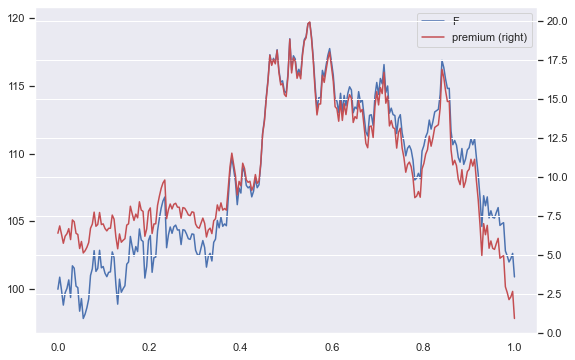

In [44]:
black_1[['F', 'premium']].plot(figsize=(9, 6), color=['b', 'r'], secondary_y=['premium']);

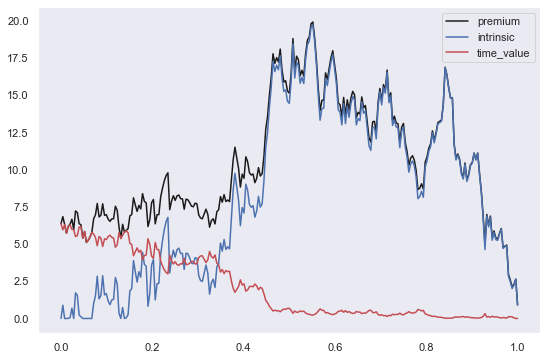

In [45]:
black_1.iloc[:, :3].plot(figsize=(9, 6), color=['k', 'b', 'r'], secondary_y=['delta']);

### Hedged Portfolio (Option + Hedge on Future)

#### Hedged Portfolio (Option + Hedge on Future) data over path

In [46]:
def hedged_path(phi, Fs, K, ttms, vol):
    n = len(ttms)
    hedged_data = pd.DataFrame([
        black_model(phi, Fs[j], K, ttms[j], vol, Fs[j])
        for j in range(n)], 
        columns=['premium', 'intrinsic', 'time_value', 'delta', 'gamma', 'gamma_1pc', 'vega', 'vega_1pc', 'theta'])
    hedged_data['F'] = Fs
    hedged_data['dF'] = hedged_data['F'].diff().fillna(0)
    hedged_data['cfw_opt'] = 0.
    hedged_data['cfw_opt'].iloc[0] = - hedged_data['premium'].iloc[0]
    hedged_data['cfw_opt'].iloc[-1] = hedged_data['premium'].iloc[-1]
    hedged_data['cfw_hedge'] = 0.
    hedged_data['cfw_hedge'].iloc[1:] = - hedged_data['delta'].iloc[:-1].values * hedged_data['dF'].iloc[1:].values
    hedged_data['cfw'] = hedged_data['cfw_opt'] + hedged_data['cfw_hedge']
    hedged_data['acc_cfw_opt'] = hedged_data['cfw_opt'].cumsum()
    hedged_data['acc_cfw_hedge'] = hedged_data['cfw_hedge'].cumsum()
    hedged_data['acc_cfw'] = hedged_data['cfw'].cumsum()
    hedged_data['prem_opt'] = 0.
    hedged_data['prem_opt'].iloc[0] = - hedged_data['premium'].iloc[0]
    hedged_data['acc_prem_opt'] = 0.
    hedged_data['acc_prem_opt'] = hedged_data['prem_opt'].cumsum()
    hedged_data['portfolio'] = hedged_data['premium'] + hedged_data['acc_prem_opt'] + hedged_data['acc_cfw_hedge']
    return hedged_data

In [47]:
def black_model_sum(Ws, phis, F, Ks, t, vol, F_t1):
    m = len(Ks)
    dfbm = pd.DataFrame([
        black_model(phis[j], F, Ks[j], t, vol, F)
        for j in range(m)], 
        columns=['premium', 'intrinsic', 'time_value', 'delta', 'gamma', 'gamma_1pc', 'vega', 'vega_1pc', 'theta'])
    return np.array(Ws).dot(dfbm).tolist()

In [48]:
def hedged_path_Ks(Ws, phis, Fs, Ks, ttms, vol):
    n = len(ttms)
    hedged_data = pd.DataFrame([
        black_model_sum(Ws, phis, Fs[j], Ks, ttms[j], vol, Fs[j])
        for j in range(n)], 
        columns=['premium', 'intrinsic', 'time_value', 'delta', 'gamma', 'gamma_1pc', 'vega', 'vega_1pc', 'theta'])
    hedged_data['F'] = Fs
    hedged_data['dF'] = hedged_data['F'].diff().fillna(0)
    hedged_data['cfw_opt'] = 0.
    hedged_data['cfw_opt'].iloc[0] = - hedged_data['premium'].iloc[0]
    hedged_data['cfw_opt'].iloc[-1] = hedged_data['premium'].iloc[-1]
    hedged_data['cfw_hedge'] = 0.
    hedged_data['cfw_hedge'].iloc[1:] = - hedged_data['delta'].iloc[:-1].values * hedged_data['dF'].iloc[1:].values
    hedged_data['cfw'] = hedged_data['cfw_opt'] + hedged_data['cfw_hedge']
    hedged_data['acc_cfw_opt'] = hedged_data['cfw_opt'].cumsum()
    hedged_data['acc_cfw_hedge'] = hedged_data['cfw_hedge'].cumsum()
    hedged_data['acc_cfw'] = hedged_data['cfw'].cumsum()
    hedged_data['prem_opt'] = 0.
    hedged_data['prem_opt'].iloc[0] = - hedged_data['premium'].iloc[0]
    hedged_data['acc_prem_opt'] = 0.
    hedged_data['acc_prem_opt'] = hedged_data['prem_opt'].cumsum()
    hedged_data['portfolio'] = hedged_data['premium'] + hedged_data['acc_prem_opt'] + hedged_data['acc_cfw_hedge']
    return hedged_data

In [49]:
def hedged_path_Ks_vols(Ws, phis, Fs, Ks, ttms, vols):
    n = len(ttms)
    hedged_data = pd.DataFrame([
        black_model_sum(Ws, phis, Fs[j], Ks, ttms[j], vols[j], Fs[j])
        for j in range(n)], 
        columns=['premium', 'intrinsic', 'time_value', 'delta', 'gamma', 'gamma_1pc', 'vega', 'vega_1pc', 'theta'])
    hedged_data['F'] = Fs
    hedged_data['dF'] = hedged_data['F'].diff().fillna(0)
    hedged_data['cfw_opt'] = 0.
    hedged_data['cfw_opt'].iloc[0] = - hedged_data['premium'].iloc[0]
    hedged_data['cfw_opt'].iloc[-1] = hedged_data['premium'].iloc[-1]
    hedged_data['cfw_hedge'] = 0.
    hedged_data['cfw_hedge'].iloc[1:] = - hedged_data['delta'].iloc[:-1].values * hedged_data['dF'].iloc[1:].values
    hedged_data['cfw'] = hedged_data['cfw_opt'] + hedged_data['cfw_hedge']
    hedged_data['acc_cfw_opt'] = hedged_data['cfw_opt'].cumsum()
    hedged_data['acc_cfw_hedge'] = hedged_data['cfw_hedge'].cumsum()
    hedged_data['acc_cfw'] = hedged_data['cfw'].cumsum()
    hedged_data['prem_opt'] = 0.
    hedged_data['prem_opt'].iloc[0] = - hedged_data['premium'].iloc[0]
    hedged_data['acc_prem_opt'] = 0.
    hedged_data['acc_prem_opt'] = hedged_data['prem_opt'].cumsum()
    hedged_data['portfolio'] = hedged_data['premium'] + hedged_data['acc_prem_opt'] + hedged_data['acc_cfw_hedge']
    return hedged_data

#### Hedged Portfolio (Option + Hedge on Future) Cashflow at he end of the path

In [50]:
def hedged_cfw(phi, Fs, K, ttms, vol):
    df = hedged_path(phi, Fs, K, ttms, vol)
    df_cfw = df[['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw']].iloc[-1]
    df_cfw['Range_Portfolio'] = df['portfolio'].max() - df['portfolio'].min()
    df_cfw['Last_F'] = df['F'].iloc[-1]
    return df_cfw

In [51]:
def hedged_cfw_Ks(Ws, phis, Fs, Ks, ttms, vol):
    df = hedged_path_Ks(Ws, phis, Fs, Ks, ttms, vol)
    df_cfw = df[['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw']].iloc[-1]
    df_cfw['Range_Portfolio'] = df['portfolio'].max() - df['portfolio'].min()
    df_cfw['Last_F'] = df['F'].iloc[-1]
    return df_cfw

In [52]:
def hedged_cfw_Ks_vols(Ws, phis, Fs, Ks, ttms, vols):
    df = hedged_path_Ks_vols(Ws, phis, Fs, Ks, ttms, vols)
    df_cfw = df[['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw']].iloc[-1]
    df_cfw['Range_Portfolio'] = df['portfolio'].max() - df['portfolio'].min()
    df_cfw['Last_F'] = df['F'].iloc[-1]
    return df_cfw

In [53]:
%%time

hedged_path(1, path1, 100, ttm1, vol0)

Wall time: 46.4 ms


,premium,intrinsic,time_value,delta,gamma,gamma_1pc,vega,vega_1pc,theta,F,dF,cfw_opt,cfw_hedge,cfw,acc_cfw_opt,acc_cfw_hedge,acc_cfw,prem_opt,acc_prem_opt,portfolio
0,6.376274,0.000000,6.376274,0.531881,0.024854,0.024854,39.766771,0.397668,-0.012637,100.000000,0.000000,-6.376274,0.000000,-6.376274,-6.376274,0.000000,-6.376274,-6.376274,-6.376274,0.000000
1,6.846624,0.889732,5.956892,0.553817,0.024537,0.024756,39.803174,0.398032,-0.012699,100.889732,0.889732,0.000000,-0.473231,-0.473231,-6.376274,-0.473231,-6.849506,0.000000,-6.376274,-0.002881
2,6.310010,0.000000,6.310010,0.529827,0.024982,0.024963,39.593905,0.395939,-0.012683,99.922823,-0.966909,0.000000,0.535491,0.535491,-6.376274,0.062259,-6.314015,0.000000,-6.376274,-0.004005
3,5.734020,0.000000,5.734020,0.502234,0.025380,0.025083,39.191938,0.391919,-0.012604,98.831203,-1.091620,0.000000,0.578370,0.578370,-6.376274,0.640629,-5.735645,0.000000,-6.376274,-0.001625
4,6.189856,0.000000,6.189856,0.525180,0.025148,0.025084,39.396034,0.393960,-0.012721,99.743156,0.911952,0.000000,-0.458013,-0.458013,-6.376274,0.182616,-6.193658,0.000000,-6.376274,-0.003803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2.578295,2.465775,0.112520,0.888379,0.091980,0.094248,2.451503,0.024515,-0.047053,102.465775,-0.356770,0.000000,0.318808,0.318808,-6.376274,3.892059,-2.484216,0.000000,-6.376274,0.094079
249,2.119984,2.008001,0.111983,0.874293,0.116015,0.118345,2.298501,0.022985,-0.058585,102.008001,-0.457774,0.000000,0.406676,0.406676,-6.376274,4.298735,-2.077539,0.000000,-6.376274,0.042445
250,2.293335,2.257043,0.036293,0.941987,0.079634,0.081432,1.054731,0.010547,-0.031513,102.257043,0.249042,0.000000,-0.217736,-0.217736,-6.376274,4.081000,-2.295275,0.000000,-6.376274,-0.001940
251,2.645960,2.644415,0.001545,0.995206,0.013568,0.013927,0.089063,0.000891,-0.001545,102.644415,0.387372,0.000000,-0.364899,-0.364899,-6.376274,3.716100,-2.660174,0.000000,-6.376274,-0.014214


In [54]:
%%time

hedged_path_Ks([+1], [+1], path1, [100.], ttm1, vol0)

Wall time: 268 ms


,premium,intrinsic,time_value,delta,gamma,gamma_1pc,vega,vega_1pc,theta,F,dF,cfw_opt,cfw_hedge,cfw,acc_cfw_opt,acc_cfw_hedge,acc_cfw,prem_opt,acc_prem_opt,portfolio
0,6.376274,0.000000,6.376274,0.531881,0.024854,0.024854,39.766771,0.397668,-0.012637,100.000000,0.000000,-6.376274,0.000000,-6.376274,-6.376274,0.000000,-6.376274,-6.376274,-6.376274,0.000000
1,6.846624,0.889732,5.956892,0.553817,0.024537,0.024756,39.803174,0.398032,-0.012699,100.889732,0.889732,0.000000,-0.473231,-0.473231,-6.376274,-0.473231,-6.849506,0.000000,-6.376274,-0.002881
2,6.310010,0.000000,6.310010,0.529827,0.024982,0.024963,39.593905,0.395939,-0.012683,99.922823,-0.966909,0.000000,0.535491,0.535491,-6.376274,0.062259,-6.314015,0.000000,-6.376274,-0.004005
3,5.734020,0.000000,5.734020,0.502234,0.025380,0.025083,39.191938,0.391919,-0.012604,98.831203,-1.091620,0.000000,0.578370,0.578370,-6.376274,0.640629,-5.735645,0.000000,-6.376274,-0.001625
4,6.189856,0.000000,6.189856,0.525180,0.025148,0.025084,39.396034,0.393960,-0.012721,99.743156,0.911952,0.000000,-0.458013,-0.458013,-6.376274,0.182616,-6.193658,0.000000,-6.376274,-0.003803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2.578295,2.465775,0.112520,0.888379,0.091980,0.094248,2.451503,0.024515,-0.047053,102.465775,-0.356770,0.000000,0.318808,0.318808,-6.376274,3.892059,-2.484216,0.000000,-6.376274,0.094079
249,2.119984,2.008001,0.111983,0.874293,0.116015,0.118345,2.298501,0.022985,-0.058585,102.008001,-0.457774,0.000000,0.406676,0.406676,-6.376274,4.298735,-2.077539,0.000000,-6.376274,0.042445
250,2.293335,2.257043,0.036293,0.941987,0.079634,0.081432,1.054731,0.010547,-0.031513,102.257043,0.249042,0.000000,-0.217736,-0.217736,-6.376274,4.081000,-2.295275,0.000000,-6.376274,-0.001940
251,2.645960,2.644415,0.001545,0.995206,0.013568,0.013927,0.089063,0.000891,-0.001545,102.644415,0.387372,0.000000,-0.364899,-0.364899,-6.376274,3.716100,-2.660174,0.000000,-6.376274,-0.014214


In [57]:
%%time

hedged_path_Ks(
    [+1, +0.5, +0.5, +1],
    [-1, -1, +1, +1],
    path1,
    [80., 100., 100., 125.], ttm1, vol0)

Wall time: 296 ms


,premium,intrinsic,time_value,delta,gamma,gamma_1pc,vega,vega_1pc,theta,F,dF,cfw_opt,cfw_hedge,cfw,acc_cfw_opt,acc_cfw_hedge,acc_cfw,prem_opt,acc_prem_opt,portfolio
0,7.568255,0.000000,7.568255,0.056041,0.043767,0.043767,70.028061,0.700281,-0.022235,100.000000,0.000000,-7.568255,0.000000,-7.568255,-7.568255,0.000000,-7.568255,-7.568255,-7.568255,0.000000
1,7.612974,0.444866,7.168108,0.094602,0.043354,0.043740,70.325871,0.703259,-0.022418,100.889732,0.889732,0.000000,-0.049862,-0.049862,-7.568255,-0.049862,-7.618116,0.000000,-7.568255,-0.005142
2,7.519615,0.038588,7.481026,0.052251,0.043833,0.043799,69.468299,0.694683,-0.022233,99.922823,-0.966909,0.000000,0.091471,0.091471,-7.568255,0.041610,-7.526645,0.000000,-7.568255,-0.007030
3,7.466793,0.584398,6.882395,0.003904,0.044351,0.043832,68.486774,0.684868,-0.022007,98.831203,-1.091620,0.000000,0.057038,0.057038,-7.568255,0.098648,-7.469607,0.000000,-7.568255,-0.002814
4,7.466535,0.128422,7.338113,0.043951,0.043945,0.043832,68.841582,0.688416,-0.022211,99.743156,0.911952,0.000000,-0.003560,-0.003560,-7.568255,0.095087,-7.473167,0.000000,-7.568255,-0.006632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1.345407,1.232887,0.112520,0.388379,0.091980,0.094248,2.451503,0.024515,-0.047053,102.465775,-0.356770,0.000000,0.140423,0.140423,-7.568255,6.422928,-1.145327,0.000000,-7.568255,0.200081
249,1.115983,1.004000,0.111983,0.374293,0.116015,0.118345,2.298501,0.022985,-0.058585,102.008001,-0.457774,0.000000,0.177790,0.177790,-7.568255,6.600718,-0.967537,0.000000,-7.568255,0.148446
250,1.164814,1.128521,0.036293,0.441987,0.079634,0.081432,1.054731,0.010547,-0.031513,102.257043,0.249042,0.000000,-0.093215,-0.093215,-7.568255,6.507503,-1.060752,0.000000,-7.568255,0.104062
251,1.323753,1.322207,0.001545,0.495206,0.013568,0.013927,0.089063,0.000891,-0.001545,102.644415,0.387372,0.000000,-0.171213,-0.171213,-7.568255,6.336290,-1.231965,0.000000,-7.568255,0.091788


In [58]:
%%time

hedged_path_Ks_vols([+1, +0.5, +0.5, +1],
                    [-1, -1, +1, +1],
                    path1,
                    [80., 100., 100., 125.],
                    ttm1, np.linspace(0.18, 0.14, len(path1)))

Wall time: 380 ms


,premium,intrinsic,time_value,delta,gamma,gamma_1pc,vega,vega_1pc,theta,F,dF,cfw_opt,cfw_hedge,cfw,acc_cfw_opt,acc_cfw_hedge,acc_cfw,prem_opt,acc_prem_opt,portfolio
0,9.038422,0.000000,9.038422,0.069181,0.042675,0.042675,76.814867,0.768149,-0.027441,100.000000,0.000000,-9.038422,0.000000,-9.038422,-9.038422,0.000000,-9.038422,-9.038422,-9.038422,0.000000
1,9.076928,0.444866,8.632062,0.106641,0.042269,0.042645,77.068536,0.770685,-0.027617,100.889732,0.889732,0.000000,-0.061553,-0.061553,-9.038422,-0.061553,-9.099975,0.000000,-9.038422,-0.023047
2,8.954164,0.038588,8.915576,0.065193,0.042777,0.042744,76.134741,0.761347,-0.027367,99.922823,-0.966909,0.000000,0.103112,0.103112,-9.038422,0.041560,-8.996862,0.000000,-9.038422,-0.042698
3,8.869579,0.584398,8.285181,0.017834,0.043318,0.042812,75.054945,0.750549,-0.027063,98.831203,-1.091620,0.000000,0.071166,0.071166,-9.038422,0.112725,-8.925697,0.000000,-9.038422,-0.056118
4,8.864533,0.128422,8.736111,0.056795,0.042926,0.042816,75.384289,0.753843,-0.027268,99.743156,0.911952,0.000000,-0.016264,-0.016264,-9.038422,0.096461,-8.941961,0.000000,-9.038422,-0.077428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1.302392,1.232887,0.069505,0.416650,0.084460,0.086542,1.977447,0.019774,-0.032323,102.465775,-0.356770,0.000000,0.150252,0.150252,-9.038422,6.319107,-2.719314,0.000000,-9.038422,-1.416922
249,1.074912,1.004000,0.070912,0.403855,0.109044,0.111234,1.895510,0.018955,-0.040738,102.008001,-0.457774,0.000000,0.190731,0.190731,-9.038422,6.509839,-2.528583,0.000000,-9.038422,-1.453671
250,1.147236,1.128521,0.018715,0.463259,0.062990,0.064412,0.729965,0.007300,-0.017058,102.257043,0.249042,0.000000,-0.100577,-0.100577,-9.038422,6.409262,-2.629160,0.000000,-9.038422,-1.481924
251,1.322606,1.322207,0.000399,0.498433,0.005685,0.005836,0.032228,0.000322,-0.000399,102.644415,0.387372,0.000000,-0.179453,-0.179453,-9.038422,6.229808,-2.808613,0.000000,-9.038422,-1.486007


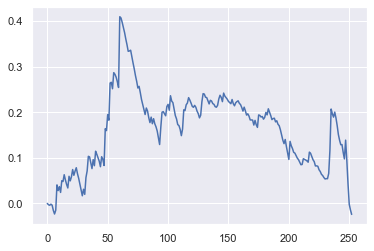

In [59]:
hedged_path(1, path1, 100, ttm1, vol0)['portfolio'].plot();

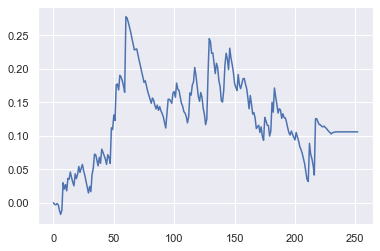

In [61]:
hedged_path_Ks([+1, +1], [-1, +1], path1, [80, 125], ttm1, vol0)['portfolio'].plot();

In [62]:
hedged_cfw(1, path1, 100, ttm1, vol0)

acc_cfw_opt         -5.467441
acc_cfw_hedge        5.443361
acc_cfw             -0.024079
Range_Portfolio      0.433399
Last_F             100.908834
Name: 252, dtype: float64

In [63]:
hedged_cfw_Ks([+1, +1], [-1, +1], path1, [80, 125], ttm1, vol0)

acc_cfw_opt         -1.191980
acc_cfw_hedge        1.297982
acc_cfw              0.106002
Range_Portfolio      0.295333
Last_F             100.908834
Name: 252, dtype: float64

In [64]:
hedged_cfw_Ks_vols([+1, +1], [-1, +1], path1, [80, 125], ttm1, np.linspace(0.18, 0.14, len(path1)))

acc_cfw_opt         -1.867143
acc_cfw_hedge        1.190307
acc_cfw             -0.676836
Range_Portfolio      0.758411
Last_F             100.908834
Name: 252, dtype: float64

In [65]:
hedged_cfw_Ks_vols([+1, +1], [-1, +1], path1, [80, 125], ttm1, np.linspace(0.14, 0.18, len(path1)))

acc_cfw_opt         -0.663136
acc_cfw_hedge        1.379342
acc_cfw              0.716206
Range_Portfolio      0.818076
Last_F             100.908834
Name: 252, dtype: float64

In [66]:
hedged_cfw_Ks_vols([+1, +1], [-1, +1], path1, [80, 125], ttm1, np.linspace(0.16, 0.16, len(path1)))

acc_cfw_opt         -1.191980
acc_cfw_hedge        1.297982
acc_cfw              0.106002
Range_Portfolio      0.295333
Last_F             100.908834
Name: 252, dtype: float64

### P&L Dispersion

In [67]:
def pnl_dispersion(s, drift_F, vol_F, df_F, tm, vol_opt, phi, K, steps, runs):
    ttms = ttm(tm, steps)
    cfws_df = pd.DataFrame(0, index=range(runs),
                          columns=['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw', 'Range_Portfolio', 'Last_F'])
    realizeds = []
    for j in range(runs):
        pathj = mc_path(s, drift_F, vol_F, tm, st_t.rvs(df_F, size=steps))
        realizeds += [realized_vol(pathj)]
        cfws_df.iloc[j] = hedged_cfw(phi, pathj, K, ttms, vol_opt)
    cfws_df['realiz_vol'] = realizeds
    return cfws_df

In [68]:
def pnl_dispersion_Ks(s, drift_F, vol_F, df_F, tm, vol_opt, Ws, phis, Ks, steps, runs):
    ttms = ttm(tm, steps)
    cfws_df = pd.DataFrame(0, index=range(runs),
                          columns=['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw', 'Range_Portfolio', 'Last_F'])
    realizeds = []
    for j in range(runs):
        pathj = mc_path(s, drift_F, vol_F, tm, st_t.rvs(df_F, size=steps))
        realizeds += [realized_vol(pathj)]
        cfws_df.iloc[j] = hedged_cfw_Ks(Ws, phis, pathj, Ks, ttms, vol_opt)
    cfws_df['realiz_vol'] = realizeds
    return cfws_df

In [69]:
def pnl_dispersion_Ks_paths(paths, tm, vol_opt, Ws, phis, Ks, steps):
    runs = len(paths)
    ttms = ttm(tm, steps)
    cfws_df = pd.DataFrame(0, index=range(runs),
                          columns=['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw', 'Range_Portfolio', 'Last_F'])
    realizeds = []
    for j in range(runs):
        realizeds += [realized_vol(paths[j])]
        cfws_df.iloc[j] = hedged_cfw_Ks(Ws, phis, paths[j], Ks, ttms, vol_opt)
    cfws_df['realiz_vol'] = realizeds
    return cfws_df

In [70]:
def pnl_dispersion_Ks_paths_vols(paths, tm, vols_opt, Ws, phis, Ks, steps):
    runs = len(paths)
    ttms = ttm(tm, steps)
    cfws_df = pd.DataFrame(0, index=range(runs),
                          columns=['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw', 'Range_Portfolio', 'Last_F'])
    realizeds = []
    for j in range(runs):
        realizeds += [realized_vol(paths[j])]
        cfws_df.iloc[j] = hedged_cfw_Ks_vols(Ws, phis, paths[j], Ks, ttms, vols_opt)
    cfws_df['realiz_vol'] = realizeds
    return cfws_df

In [71]:
path_N = mc_path(s0, drift0, vol0, t0, st_t.rvs(df=10**9, size=steps0, random_state=seed))
path_10 = mc_path(s0, drift0, vol0, t0, st_t.rvs(df=10, size=steps0, random_state=seed))
path_5 = mc_path(s0, drift0, vol0, t0, st_t.rvs(df=5, size=steps0, random_state=seed))
path_3 = mc_path(s0, drift0, vol0, t0, st_t.rvs(df=3, size=steps0, random_state=seed))

In [72]:
%%time

pnl_dispersion_Ks_paths([path_N, path_10, path_5, path_3], t0, vol0,
                        [+1, +0.5, +0.5, +1],
                        [-1, -1, +1, +1],
                        [80., 100., 100., 125.], steps0)

Wall time: 955 ms


,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
0,-7.113838,7.195760,0.081923,0.727825,100.908834,0.162219
1,-1.003838,2.163856,1.160018,1.214399,113.128834,0.176695
2,28.570789,-25.470061,3.100728,3.226758,140.759362,0.210209
3,-3.599147,17.465767,13.866620,13.917748,92.061784,0.289956


### Total Error P&L Dispersion

In [73]:
def mean_abs_end_cfw_Ks_paths(paths, tm, vol_opt, Ws, phis, Ks, steps):
    runs = len(paths)
    ttms = ttm(tm, steps)
    cfws_df = pd.DataFrame(0, index=range(runs),
                          columns=['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw', 'Range_Portfolio', 'Last_F'])
    realizeds = []
    for j in range(runs):
        realizeds += [realized_vol(paths[j])]
        cfws_df.iloc[j] = hedged_cfw_Ks(Ws, phis, paths[j], Ks, ttms, vol_opt)
    # cfws_df['realiz_vol'] = realizeds
    return np.mean(np.abs(cfws_df['acc_cfw']))

In [74]:
def mean_abs_end_cfw_Ks_paths_vols(paths, tm, vols_opt, Ws, phis, Ks, steps):
    runs = len(paths)
    ttms = ttm(tm, steps)
    cfws_df = pd.DataFrame(0, index=range(runs),
                          columns=['acc_cfw_opt', 'acc_cfw_hedge', 'acc_cfw', 'Range_Portfolio', 'Last_F'])
    realizeds = []
    for j in range(runs):
        realizeds += [realized_vol(paths[j])]
        cfws_df.iloc[j] = hedged_cfw_Ks_vols(Ws, phis, paths[j], Ks, ttms, vols_opt)
    # cfws_df['realiz_vol'] = realizeds
    return np.mean(np.abs(cfws_df['acc_cfw']))

### Minimization Total Error P&L Dispersion

####  Function for Minimization Total Error P&L Dispersion

In [75]:
def minim(paths, tm, vols_opt_x0, Ws, phis, Ks, steps,
          param_bounds=[0.001, 1.00],
          tol=0.001, maxiter=50, iprint=0,
          prtm=True):
    bounds=len(vols_opt_x0)*[param_bounds]
    error_history = []
    vols_history = []
    def fmin(x):
        return mean_abs_end_cfw_Ks_paths_vols(paths, tm, x, Ws, phis, Ks, steps)
    def callback(x):
        vols_history.append(x)
        fobj = fmin(x)
        print(np.log(fobj))
        error_history.append(fobj)
    if prtm:
        start_time = time.time()
    awmin=minimize(fmin, vols_opt_x0, method='L-BFGS-B', bounds=bounds, callback=callback,
                   tol=tol, options={'iprint':iprint, 'maxiter':maxiter})
    if prtm:
        print("--- %s seconds ---" % (time.time() - start_time))
    # dfawv=pd.DataFrame(np.transpose(np.array(awmin.x)), columns=['a0'])
    error_history = [mean_abs_end_cfw_Ks_paths_vols(paths, tm, vols_opt_x0, Ws, phis, Ks, steps)] + error_history
    serr=pd.Series(error_history, name='Error')
    vols_history = [vols_opt_x0] + vols_history
    dfvols = pd.DataFrame(np.transpose(np.array(vols_history)))
    return [dfvols, serr]

####  Explore P&L Dispersion

In [409]:
s1 = 100.
drift1 = 0.
vol1 = 0.16
t1 = 1.
steps1 = 252
runs1 = 1000

In [410]:
df1 = 10**9
paths_N = [mc_path(s1, drift1, vol1, t1, st_t.rvs(df=df1, size=steps1)) for j in range(runs1)]

In [411]:
df1 = 10
paths_10 = [mc_path(s1, drift1, vol1 / np.sqrt(df1 / (df1 - 2)), t1, st_t.rvs(df=df1, size=steps1)) for j in range(runs1)]

In [412]:
df1 = 5
paths_5 = [mc_path(s1, drift1, vol1 / np.sqrt(df1 / (df1 - 2)), t1, st_t.rvs(df=df1, size=steps1)) for j in range(runs1)]

In [413]:
df1 = 3
paths_3 = [mc_path(s1, drift1, vol1 / np.sqrt(df1 / (df1 - 2)), t1, st_t.rvs(df=df1, size=steps1)) for j in range(runs1)]

In [423]:
df1 = 2.5
paths_2pt5 = [mc_path(s1, drift1, vol1 / np.sqrt(df1 / (df1 - 2)), t1, st_t.rvs(df=df1, size=steps1)) for j in range(runs1)]

In [414]:
df1 = 2.1
paths_2pt1 = [mc_path(s1, drift1, vol1 / np.sqrt(df1 / (df1 - 2)), t1, st_t.rvs(df=df1, size=steps1)) for j in range(runs1)]

In [415]:
%%time

mean_abs_end_cfw_Ks_paths_vols(
    paths_N, t1, np.linspace(0.16, 0.16, len(paths_N[0])),
    [+1, +0.5, +0.5, +1], [-1, -1, +1, +1],
    [80., 100., 100., 125.], steps1)

Wall time: 4min 27s


0.4051001902885199

In [406]:
vol1 / np.sqrt(3)

0.09237604307034013

In [407]:
vol1 / np.sqrt(2.1/0.1)

0.034914862437758785

In [416]:
range_vols = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.16, 0.17, 0.18, 0.19]

In [417]:
%%time

errors = pd.DataFrame([[
    mean_abs_end_cfw_Ks_paths(
        path_set, t1, vol,
        [+1, +0.5, +0.5, +1],
        [-1, -1, +1, +1],
        [80., 100., 100., 125.],
        steps1) for path_set in [paths_N, paths_10, paths_5, paths_3, paths_2pt5]]
    for vol in range_vols],
    index=range_vols, columns=['Normal', 'StT(10)', 'StT(5)', 'StT(3)', 'StT(2.1)'])

Wall time: 4h 41min 7s


In [424]:
%%time

errors_2 = pd.DataFrame([[
    mean_abs_end_cfw_Ks_paths(
        path_set, t1, vol,
        [+1, +0.5, +0.5, +1],
        [-1, -1, +1, +1],
        [80., 100., 100., 125.],
        steps1) for path_set in [paths_N, paths_2pt5, paths_2pt1]]
    for vol in range_vols],
    index=range_vols, columns=['Normal', 'StT(2.5)', 'StT(2.1)'])

Wall time: 2h 41min 28s


In [418]:
errors

,Normal,StT(10),StT(5),StT(3),StT(2.1)
0.01,7.033029,7.012257,7.304254,6.864824,4.083750
0.03,6.296130,6.251136,6.507118,6.176002,3.262854
0.05,5.529633,5.519217,5.695515,5.449065,2.480580
0.07,4.741368,4.765131,4.871231,4.688009,1.837362
0.09,3.915327,3.955360,4.013696,3.874941,1.827567
0.11,2.988690,3.028627,3.062905,2.951761,2.340763
0.13,1.912272,1.941529,1.968599,1.933306,3.165397
0.15,0.716327,0.774331,0.908048,1.402437,4.242638
0.16,0.405100,0.527883,0.766920,1.525405,4.855149
0.17,0.760201,0.830787,1.044008,1.887335,5.511836


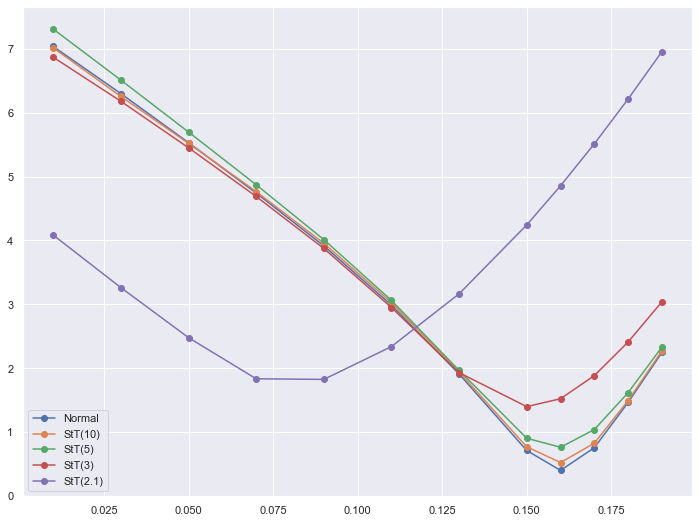

In [419]:
errors.plot(figsize=(12, 9), marker='o', );
plt.ylim(bottom=0);

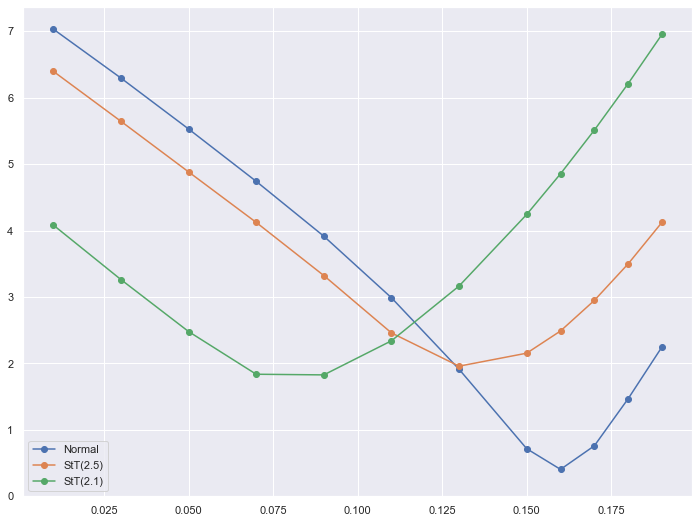

In [425]:
errors_2.plot(figsize=(12, 9), marker='o', );
plt.ylim(bottom=0);

In [421]:
errors_RV = pd.DataFrame({
    'Normal':[realized_vol(p) for p in paths_N],
    'StT(10)':[realized_vol(p) for p in paths_10],
    'StT(5)':[realized_vol(p) for p in paths_5],
    'StT(3)':[realized_vol(p) for p in paths_3],
    'StT(2.1)':[realized_vol(p) for p in paths_2pt1]})

In [422]:
errors_RV.describe()

,Normal,StT(10),StT(5),StT(3),StT(2.1)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.159583,0.159372,0.159575,0.156561,0.093326
std,0.006801,0.008811,0.014467,0.040315,0.072916
min,0.138892,0.135774,0.129080,0.109085,0.048698
25%,0.155207,0.153252,0.150752,0.139188,0.070806
50%,0.159789,0.159356,0.158044,0.150097,0.080362
75%,0.163988,0.165154,0.166616,0.163900,0.095784
max,0.182668,0.199292,0.359600,1.061850,1.180398


In [428]:
errors_2_RV = pd.DataFrame({
    'Normal':[realized_vol(p) for p in paths_N],
    'StT(2.5)':[realized_vol(p) for p in paths_2pt5],
    'StT(2.1)':[realized_vol(p) for p in paths_2pt1]})

In [429]:
errors_2_RV.describe()

,Normal,StT(2.5),StT(2.1)
count,1000.000000,1000.000000,1000.000000
mean,0.159583,0.144802,0.093326
std,0.006801,0.047032,0.072916
min,0.138892,0.095355,0.048698
25%,0.155207,0.120318,0.070806
50%,0.159789,0.134647,0.080362
75%,0.163988,0.152789,0.095784
max,0.182668,0.586655,1.180398


In [363]:
s2 = 100.
drift2 = 0.
vol2 = 0.16
t2 = 1/4.
steps2 = 63
Ws2 = [+1, +1, +1, +0.5, +0.5, +1, +1, +1]
phis2 = [-1, -1, -1, -1, +1, +1, +1, +1]
Ks2 = [60., 80., 90., 100., 100., 110., 125., 150.]
tol2 = 0.01
maxiter2 = 10
nr_paths2 = 10

In [364]:
%%time

df_t = 10**9
teste_N_paths = [mc_path(s2, drift2, vol2, t2,
                         st_t.rvs(df=df_t, size=steps2)) for j in range(nr_paths2)]
mean_abs_end_cfw_Ks_paths_vols(teste_N_paths, t2, np.full(steps2 + 1, vol2), Ws2, phis2, Ks2, steps2)

Wall time: 1.01 s


0.38303087455377866

####  Minimize P&L Dispersion

In [365]:
%%time

teste_N_vols, teste_N_errors = minim(
    teste_N_paths, t2, np.full(steps2 + 1, vol2),
    Ws2, phis2, Ks2, steps2,
    tol=tol2, maxiter=maxiter2, iprint=1, prtm=True)

-1.0932792015361108
-1.0982595196773788
--- 428.5685636997223 seconds ---
Wall time: 7min 9s


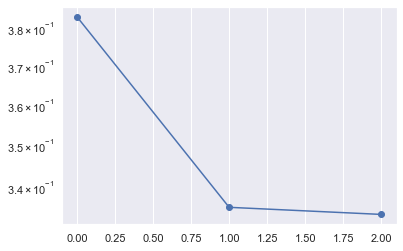

In [366]:
teste_N_errors.plot(logy=True, marker='o');

In [331]:
# teste_N_vols.iloc[:, [0, -1]].plot(figsize=(9, 6), marker='o', linestyle='None');

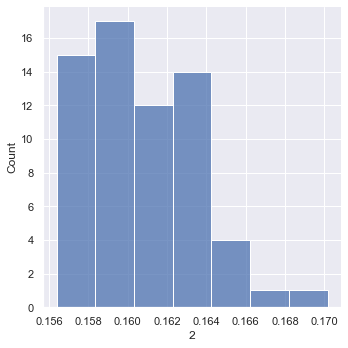

In [367]:
sns.displot(teste_N_vols.iloc[:, -1], kind='hist', height=5);

In [368]:
%%time

df_t = 10
teste_10_paths = [mc_path(s2, drift2, vol2 / np.sqrt(df_t / (df_t - 2)), t2,
                         st_t.rvs(df=df_t, size=steps2)) for j in range(nr_paths2)]
teste_10_vols, teste_10_errors = minim(
    teste_10_paths, t2, np.full(steps2 + 1, vol2),
    Ws2, phis2, Ks2, steps2,
    tol=tol2, maxiter=maxiter2, iprint=1, prtm=True)

-0.9987045110487145
-1.0987933193844142
-1.170434690082467
-1.1907475998975117
--- 695.1657843589783 seconds ---
Wall time: 11min 36s


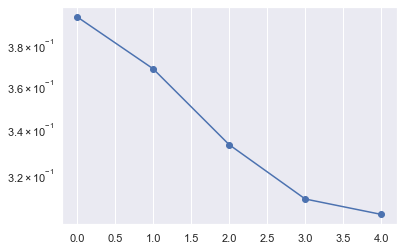

In [369]:
teste_10_errors.plot(logy=True, marker='o');

In [339]:
# teste_10_vols.iloc[:, [0, -1]].plot(figsize=(9, 6), marker='o', linestyle='None');

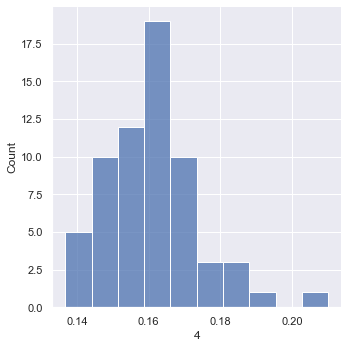

In [370]:
sns.displot(teste_10_vols.iloc[:, -1], kind='hist', height=5);

In [371]:
%%time

df_t = 5
teste_5_paths = [mc_path(s2, drift2, vol2 / np.sqrt(df_t / (df_t - 2)), t2,
                         st_t.rvs(df=df_t, size=steps2)) for j in range(nr_paths2)]
teste_5_vols, teste_5_errors = minim(
    teste_5_paths, t2, np.full(steps2 + 1, vol2),
    Ws2, phis2, Ks2, steps2,
    tol=tol2, maxiter=maxiter2, iprint=1, prtm=True)

-0.6500428900526196
-0.6910621441439567
-0.7819484178513283
-1.05029935077141
-1.0809379508833086
-1.1427301582045677
-1.1757535519795068
-1.17778042156793
--- 1378.2437047958374 seconds ---
Wall time: 22min 59s


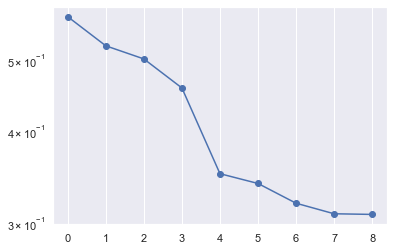

In [372]:
teste_5_errors.plot(logy=True, marker='o');

In [352]:
# teste_5_vols.iloc[:, [0, -1]].plot(figsize=(9, 6), marker='o', linestyle='None');

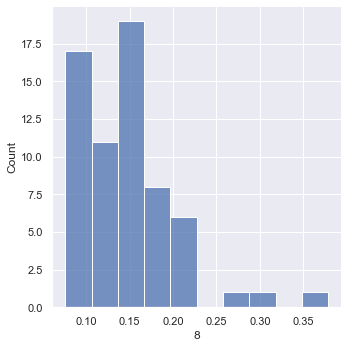

In [373]:
sns.displot(teste_5_vols.iloc[:, -1], kind='hist', height=5);

In [374]:
%%time

df_t = 3
teste_3_paths = [mc_path(s2, drift2, vol2 / np.sqrt(df_t / (df_t - 2)), t2,
                         st_t.rvs(df=df_t, size=steps2)) for j in range(nr_paths2)]
teste_3_vols, teste_3_errors = minim(
    teste_3_paths, t2, np.full(steps2 + 1, vol2),
    Ws2, phis2, Ks2, steps2,
    tol=tol2, maxiter=maxiter2, iprint=1, prtm=True)

-0.27117239746297017
-0.2889600915174805
-0.29269679546577304
--- 999.5257160663605 seconds ---
Wall time: 16min 40s


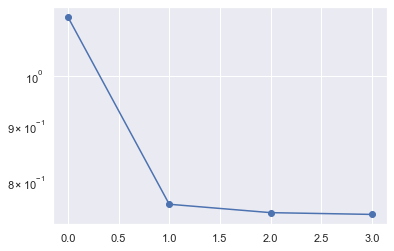

In [377]:
teste_3_errors.plot(logy=True, marker='o');

In [353]:
# teste_3_vols.iloc[:, [0, -1]].plot(figsize=(9, 6), marker='o', linestyle='None');

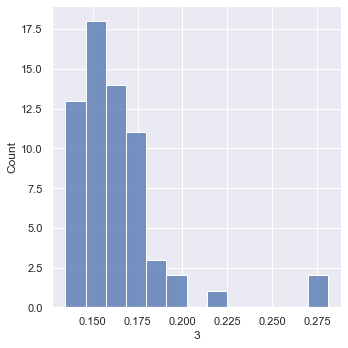

In [378]:
sns.displot(teste_3_vols.iloc[:, -1], kind='hist', height=5);

## Examples

In [66]:
runs0 = 10000

In [77]:
black_model(1, s0, 125, t0, vol0, s0)

[0.6622113272581576,
 0,
 0.6622113272581576,
 0.09431551413460859,
 0.01050741640380437,
 0.01050741640380437,
 16.811827910589994,
 0.16811827910589994,
 -0.005332103030738722]

### Normal

#### ATM

In [81]:
%%time

df0 = 10**9
phi0 = +1
K0 = 100.
pnl_disp_df_Normal_ATM = pnl_dispersion(s0, drift0, vol0, df0, t0, vol0, phi0, K0, steps0, runs0)

Wall time: 5min 41s


In [82]:
pnl_disp_df_Normal_ATM.head()

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
0,-6.376274,6.367899,-0.008375,0.202034,75.542042,0.157509
1,7.858660,-7.979654,-0.120994,0.356145,114.234935,0.150681
2,-6.376274,6.544502,0.168228,0.512558,85.265495,0.165881
3,-6.376274,6.119809,-0.256465,0.361678,75.242216,0.155985
4,-6.376274,6.815208,0.438934,0.488689,89.917730,0.169339


In [83]:
pnl_disp_df_Normal_ATM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.205542,0.201790,-0.003751,0.490857,99.770063,0.159455
std,10.112715,10.104594,0.357075,0.245499,15.939664,0.007188
min,-6.376274,-80.225216,-2.119966,0.071196,53.612677,0.135114
1%,-6.376274,-36.654896,-0.935446,0.135852,68.178355,0.143110
5%,-6.376274,-21.179843,-0.575944,0.187557,75.844242,0.147780
15%,-6.376274,-9.605644,-0.330703,0.258378,83.529874,0.152110
50%,-6.376274,5.928306,-0.007174,0.439951,98.632717,0.159343
85%,9.673965,6.541219,0.321531,0.727804,116.050240,0.166905
95%,21.286210,6.798547,0.570447,0.964768,127.662484,0.171471


#### OTM

In [85]:
%%time

df0 = 10**9
phi0 = +1
K0 = 125.
pnl_disp_df_Normal_OTM = pnl_dispersion(s0, drift0, vol0, df0, t0, vol0, phi0, K0, steps0, runs0)

C:\ProgramData\Miniconda3\envs\mcsc\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Wall time: 6min 29s


In [229]:
pnl_disp_df_Normal_OTM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.041624,-0.040137,0.001486,0.233206,100.236525,0.159462
std,3.438526,3.423512,0.234779,0.257759,16.200439,0.007072
min,-0.662211,-63.934739,-2.032297,0.013168,55.768510,0.133507
1%,-0.662211,-17.991784,-0.733753,0.024794,67.952969,0.143400
5%,-0.662211,-3.135993,-0.314105,0.037416,76.014151,0.148037
15%,-0.662211,0.483559,-0.117110,0.056248,83.729955,0.152120
50%,-0.662211,0.652540,-0.001434,0.130292,99.106154,0.159466
85%,-0.662211,0.751061,0.116892,0.445121,116.811795,0.166719
95%,3.330562,0.892711,0.339350,0.773249,128.992773,0.171045


#### OTM P + ATM P+C + OTM C

In [90]:
%%time

df0 = 10**9
Ws0 = [+0.5, +0.5]
phis0 = [-1, +1]
Ks0 = [100., 100.]
pnl_disp_df_Normal_Straddle = pnl_dispersion_Ks(s0, drift0, vol0, df0, t0, vol0, Ws0, phis0, Ks0, steps0, 1000)

Wall time: 2min 58s


In [91]:
pnl_disp_df_Normal_Straddle.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.303136,-0.289515,0.013620,0.478461,99.980647,0.159590
std,5.098465,5.087189,0.358113,0.248915,16.811119,0.007073
min,-6.372468,-34.354972,-1.383404,0.109481,60.793324,0.133092
1%,-6.279506,-15.048368,-0.893477,0.141675,66.827202,0.143566
5%,-5.849678,-9.824754,-0.529385,0.188708,73.606726,0.147532
15%,-4.791360,-5.534752,-0.317118,0.246164,83.149217,0.152476
50%,-0.807747,0.804195,0.004373,0.424609,98.353465,0.159720
85%,5.513815,4.725099,0.320393,0.711044,118.052822,0.166548
95%,9.782616,5.852282,0.602273,0.945690,129.360385,0.171061


In [69]:
%%time

df0 = 10**9
Ws0 = [+1, +0.5, +0.5, +1]
phis0 = [-1, -1, +1, +1]
Ks0 = [80., 100., 100., 125.]
pnl_disp_df_Normal_IOTM = pnl_dispersion_Ks(s0, drift0, vol0, df0, t0, vol0, Ws0, phis0, Ks0, steps0, 1000)

Wall time: 5min 4s


In [70]:
pnl_disp_df_Normal_IOTM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.303838,0.294649,-0.009189,0.796663,99.605555,0.159368
std,13.033376,13.006282,0.547617,0.291314,15.922364,0.007384
min,-7.568255,-92.519575,-1.768273,0.193180,58.342255,0.136697
1%,-7.568255,-61.939942,-1.238180,0.339645,68.094435,0.142621
5%,-7.568255,-23.206911,-0.912590,0.435490,75.945241,0.146796
15%,-7.568255,-7.536097,-0.565896,0.523374,84.227424,0.151845
50%,-6.063128,6.155060,-0.006987,0.735144,98.160887,0.159503
85%,7.566382,7.737654,0.497758,1.081087,114.897001,0.166612
95%,23.475426,8.079839,0.937292,1.360730,128.021840,0.171573


### StT(10)

#### ATM

In [87]:
%%time

df0 = 10
phi0 = +1
K0 = 100.
pnl_disp_df_10_ATM = pnl_dispersion(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phi0, K0, steps0, runs0)

Wall time: 7min 53s


In [88]:
pnl_disp_df_10_ATM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.075236,-0.077595,-0.002359,0.570371,100.196246,0.159442
std,10.306125,10.298252,0.425338,0.298061,16.041789,0.008613
min,-6.376274,-78.245929,-1.864701,0.082681,54.824589,0.130341
1%,-6.376274,-36.842340,-1.050264,0.152665,67.908920,0.140274
5%,-6.376274,-21.830687,-0.674930,0.215840,76.119643,0.145730
15%,-6.376274,-10.581692,-0.381578,0.293960,84.001587,0.150514
50%,-6.376274,5.819915,-0.019816,0.509241,98.875459,0.159185
85%,10.635208,6.552543,0.373640,0.851269,117.011482,0.168326
95%,21.946044,6.868911,0.710642,1.128206,128.322318,0.174194


#### OTM

In [89]:
%%time

df0 = 10
phi0 = +1
K0 = 125.
pnl_disp_df_10_OTM = pnl_dispersion(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phi0, K0, steps0, runs0)

C:\ProgramData\Miniconda3\envs\mcsc\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Wall time: 7min 24s


In [90]:
pnl_disp_df_10_OTM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.046076,-0.049821,-0.003746,0.275417,100.405633,0.159403
std,3.489152,3.478843,0.280361,0.305413,16.253007,0.008707
min,-0.662211,-54.997183,-2.328537,0.015945,54.120693,0.132143
1%,-0.662211,-17.942537,-0.879637,0.028615,67.800913,0.140463
5%,-0.662211,-3.205799,-0.387914,0.042940,76.138797,0.145486
15%,-0.662211,0.448557,-0.151916,0.064560,84.055797,0.150401
50%,-0.662211,0.644890,-0.008729,0.155244,98.970952,0.159204
85%,-0.662211,0.764652,0.128730,0.535723,117.135690,0.168374
95%,3.306024,0.946305,0.393864,0.925217,128.968235,0.174133


#### OTM P + ATM P+C + OTM C

In [73]:
%%time

df0 = 10
phis0 = [-1, +1, +1]
Ks0 = [80., 100., 125.]
pnl_disp_df_10_IOTM = pnl_dispersion_Ks(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phis0, Ks0, steps0, 1000)

Wall time: 5min 3s


In [74]:
pnl_disp_df_10_IOTM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.804499,-0.813725,-0.009226,0.940585,101.279274,0.159418
std,12.528212,12.526938,0.671130,0.370704,16.318027,0.008717
min,-7.568255,-76.893227,-2.235815,0.321017,59.176411,0.134550
1%,-7.568255,-51.407904,-1.575196,0.411871,66.488184,0.140223
5%,-7.568255,-25.631211,-1.037977,0.501738,75.863037,0.145767
15%,-7.568255,-10.530351,-0.643835,0.593689,84.618516,0.150776
50%,-4.712330,4.797421,-0.042377,0.875168,100.334349,0.158946
85%,10.594002,7.639173,0.648169,1.296042,117.861166,0.168424
95%,25.803749,8.183151,1.160302,1.647855,129.186002,0.173588


### StT(5)

#### ATM

In [91]:
%%time

df0 = 5
phi0 = +1
K0 = 100.
pnl_disp_df_5_ATM = pnl_dispersion(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phi0, K0, steps0, runs0)

Wall time: 6min 40s


In [92]:
pnl_disp_df_5_ATM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.429944,-0.434677,-0.004733,0.742237,100.788288,0.159098
std,10.615711,10.593447,0.640011,0.483282,16.249419,0.012765
min,-6.376274,-80.553193,-2.269983,0.092523,53.587347,0.122506
1%,-6.376274,-37.201449,-1.331556,0.183371,68.325131,0.135133
5%,-6.376274,-22.363236,-0.884774,0.261158,76.437059,0.140984
15%,-6.376274,-11.183497,-0.528766,0.367223,84.161246,0.146865
50%,-6.376274,5.519618,-0.055612,0.635714,99.603341,0.157986
85%,11.214908,6.579688,0.495611,1.106249,117.591183,0.170904
95%,22.496901,7.035134,1.015991,1.523154,128.873176,0.179979


#### OTM

In [93]:
%%time

df0 = 5
phi0 = +1
K0 = 125.
pnl_disp_df_5_OTM = pnl_dispersion(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phi0, K0, steps0, runs0)

C:\ProgramData\Miniconda3\envs\mcsc\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Wall time: 6min 19s


In [94]:
pnl_disp_df_5_OTM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.060287,-0.056052,0.004235,0.354278,100.409391,0.159304
std,3.574587,3.553414,0.467641,0.485675,16.249156,0.012995
min,-0.662211,-62.194258,-2.360077,0.013786,53.778283,0.124275
1%,-0.662211,-17.394109,-1.079469,0.031966,68.802034,0.135094
5%,-0.662211,-3.402014,-0.504129,0.048490,76.204853,0.141080
15%,-0.662211,0.366147,-0.201778,0.074656,83.841118,0.147065
50%,-0.662211,0.629933,-0.020553,0.188979,99.114714,0.158168
85%,-0.662211,0.788709,0.170863,0.688102,117.057456,0.171081
95%,3.381183,1.062484,0.562756,1.173825,129.043394,0.181119


#### OTM P + ATM P+C + OTM C

In [76]:
%%time

df0 = 5
phis0 = [-1, +1, +1]
Ks0 = [80., 100., 125.]
pnl_disp_df_5_IOTM = pnl_dispersion_Ks(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phis0, Ks0, steps0, 1000)

Wall time: 5min 1s


In [77]:
pnl_disp_df_5_IOTM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.256512,-0.283565,-0.027053,1.231072,100.461618,0.158728
std,13.633693,13.566646,0.990156,0.651904,16.256181,0.012874
min,-7.568255,-91.721904,-2.174158,0.404554,54.277598,0.127394
1%,-7.568255,-58.842282,-1.845663,0.505458,69.479342,0.135550
5%,-7.568255,-27.151145,-1.320011,0.602726,76.404303,0.140217
15%,-7.568255,-9.080867,-0.940435,0.725699,83.925656,0.146784
50%,-6.022891,5.688788,-0.127188,1.080568,99.828745,0.157633
85%,8.955636,7.734078,0.778492,1.688518,116.448813,0.170193
95%,26.739792,8.486283,1.647924,2.342255,129.654024,0.180946


### StT(3)

#### ATM

In [95]:
%%time

df0 = 3
phi0 = +1
K0 = 100.
pnl_disp_df_3_ATM = pnl_dispersion(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phi0, K0, steps0, runs0)

Wall time: 6min 7s


In [96]:
pnl_disp_df_3_ATM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.420155,-0.511562,-0.091407,1.325693,100.846886,0.155475
std,10.895219,10.672585,1.956667,1.745406,16.409217,0.033574
min,-6.376274,-168.428237,-3.028453,0.130349,46.181234,0.107017
1%,-6.376274,-37.810011,-2.176280,0.274107,67.463877,0.118082
5%,-6.376274,-22.369026,-1.642245,0.403122,76.792772,0.125407
15%,-6.376274,-10.658274,-1.119446,0.575173,84.541423,0.132880
50%,-6.376274,4.821901,-0.365306,1.030534,99.737182,0.149053
85%,10.678992,6.458105,0.672664,1.837798,117.055266,0.174366
95%,22.840712,7.503154,2.068333,2.810390,129.216986,0.204361


#### OTM

In [97]:
%%time

df0 = 3
phi0 = +1
K0 = 125.
pnl_disp_df_3_OTM = pnl_dispersion(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phi0, K0, steps0, runs0)

C:\ProgramData\Miniconda3\envs\mcsc\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Wall time: 6min 27s


In [98]:
pnl_disp_df_3_OTM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.132989,-0.096557,0.036432,0.644242,100.736347,0.155455
std,4.878933,3.978891,2.475330,2.470864,16.525296,0.034188
min,-0.662211,-91.930447,-3.559855,0.018015,44.546807,0.107511
1%,-0.662211,-18.423790,-1.693592,0.046030,68.538797,0.117988
5%,-0.662211,-2.688540,-0.902921,0.069773,76.509857,0.126016
15%,-0.662211,0.118710,-0.418659,0.112024,84.466447,0.133455
50%,-0.662211,0.552604,-0.095031,0.287263,99.417434,0.149119
85%,-0.662211,0.777105,0.173634,1.021401,116.851604,0.174429
95%,2.822665,1.215768,0.862574,1.911133,128.484877,0.201065


#### OTM P + ATM P+C + OTM C

In [79]:
%%time

df0 = 3
phis0 = [-1, +1, +1]
Ks0 = [80., 100., 125.]
pnl_disp_df_3_IOTM = pnl_dispersion_Ks(s0, drift0, vol0 / np.sqrt(df0 / (df0 - 2)), df0, t0, vol0, phis0, Ks0, steps0, 1000)

Wall time: 5min 12s


In [80]:
pnl_disp_df_3_IOTM.describe(percentiles=[0.01, 0.05, 0.15, 0.50, 0.85, 0.95, 0.99])

,acc_cfw_opt,acc_cfw_hedge,acc_cfw,Range_Portfolio,Last_F,realiz_vol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.060689,-0.116731,-0.056042,2.251692,100.567408,0.155363
std,12.296109,11.862615,3.306752,2.937277,15.748478,0.030589
min,-7.568255,-78.349359,-4.109444,0.569399,54.614187,0.112733
1%,-7.568255,-47.429276,-2.923214,0.728115,70.493028,0.118167
5%,-7.568255,-24.014501,-2.328012,0.929140,77.482647,0.124885
15%,-7.568255,-9.857996,-1.817688,1.136977,84.151551,0.132602
50%,-5.457689,5.028212,-0.651060,1.734943,99.605651,0.150008
85%,9.778090,7.442718,1.123076,2.681921,116.930921,0.174468
95%,24.717067,8.846254,3.553749,4.907164,128.642661,0.202849


## Charts

### Joint DF

In [99]:
def add_col(df, col_name, label):
    new_df = df.copy()
    new_df[col_name] = label
    return new_df

In [100]:
all_df = pd.concat([
    add_col(add_col(pnl_disp_df_Normal_ATM, 'Dist', 'Normal'), 'K', 'ATM'),
    add_col(add_col(pnl_disp_df_Normal_OTM, 'Dist', 'Normal'), 'K', 'OTM'),
    add_col(add_col(pnl_disp_df_10_ATM, 'Dist', 'StT(10)'), 'K', 'ATM'),
    add_col(add_col(pnl_disp_df_10_OTM, 'Dist', 'StT(10)'), 'K', 'OTM'),
    add_col(add_col(pnl_disp_df_5_ATM, 'Dist', 'StT(5)'), 'K', 'ATM'),
    add_col(add_col(pnl_disp_df_5_OTM, 'Dist', 'StT(5)'), 'K', 'OTM'),
    add_col(add_col(pnl_disp_df_3_ATM, 'Dist', 'StT(3)'), 'K', 'ATM'),
    add_col(add_col(pnl_disp_df_3_OTM, 'Dist', 'StT(3)'), 'K', 'OTM')])

### Histograms

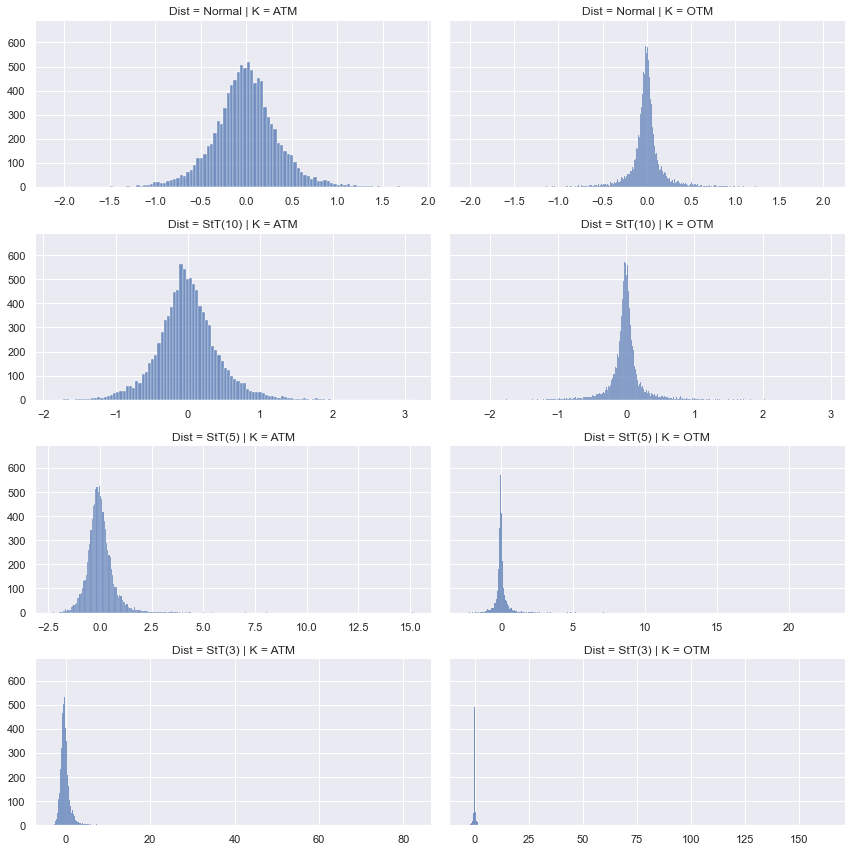

In [101]:
g_all = sns.FacetGrid(all_df, row='Dist', col='K', sharex=False, height=3, aspect=2);
g_all.map_dataframe(sns.histplot, x='acc_cfw');

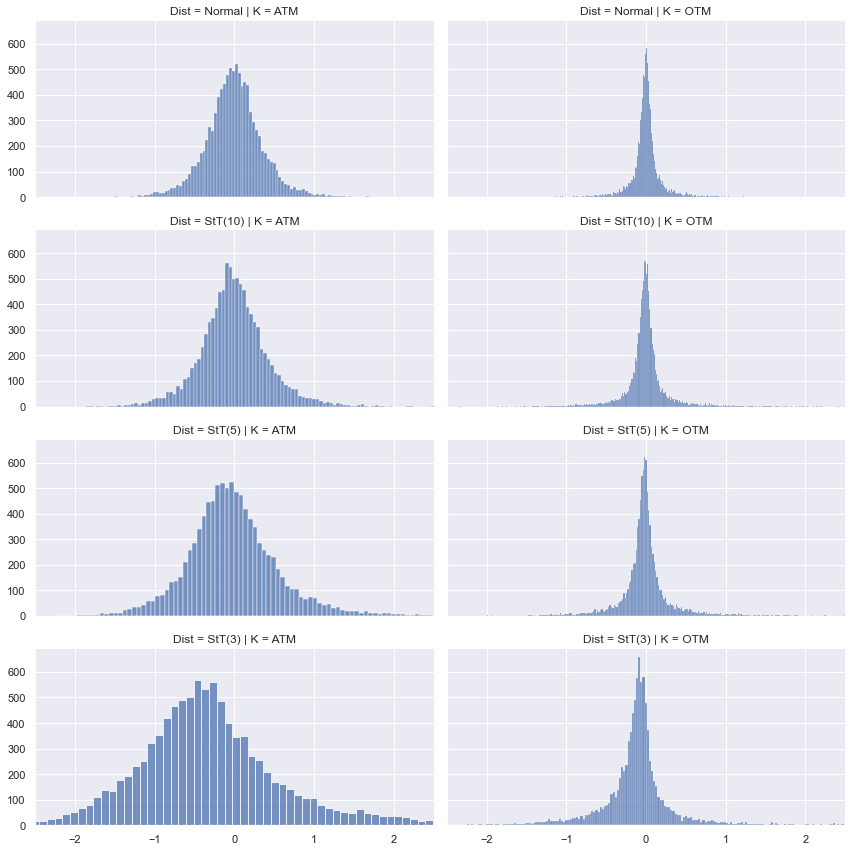

In [180]:
g_all = sns.FacetGrid(all_df, row='Dist', col='K', xlim=(-2.5, +2.5), height=3, aspect=2);
g_all.map_dataframe(sns.histplot, x='acc_cfw');

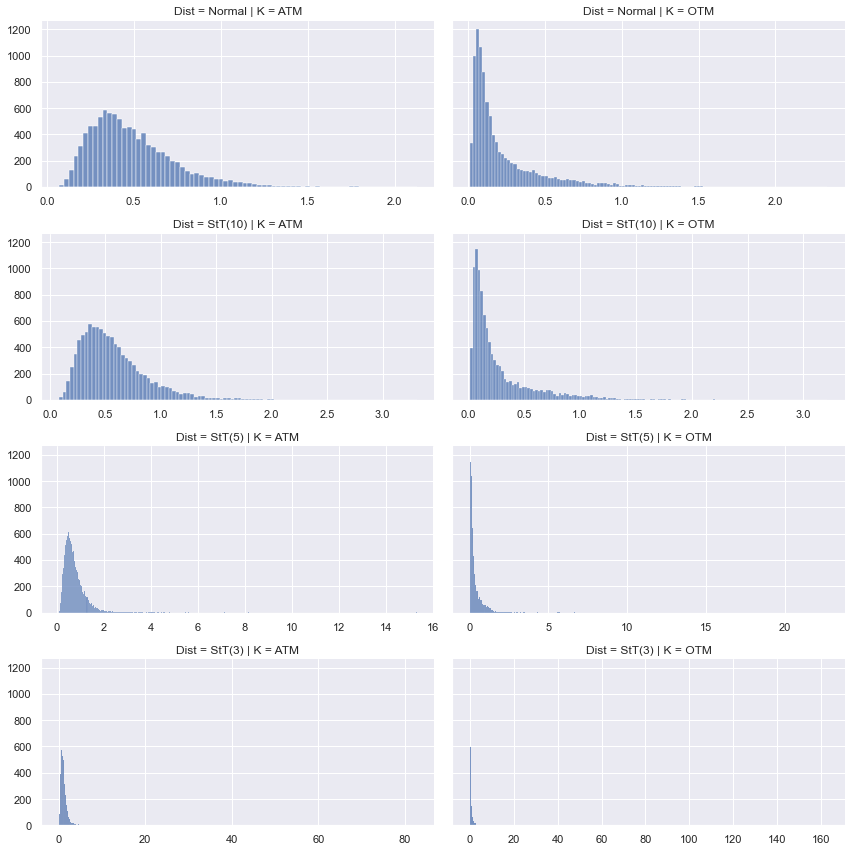

In [102]:
g_all = sns.FacetGrid(all_df, row='Dist', col='K', sharex=False, height=3, aspect=2);
g_all.map_dataframe(sns.histplot, x='Range_Portfolio');

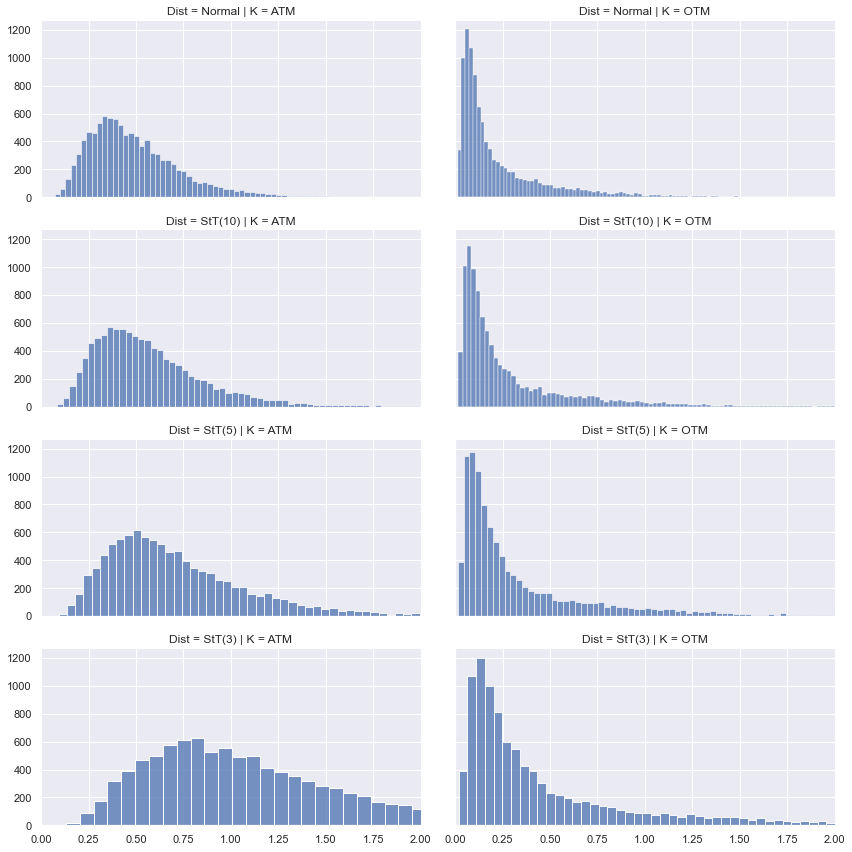

In [181]:
g_all = sns.FacetGrid(all_df, row='Dist', col='K', xlim=(0, 2), height=3, aspect=2);
g_all.map_dataframe(sns.histplot, x='Range_Portfolio');

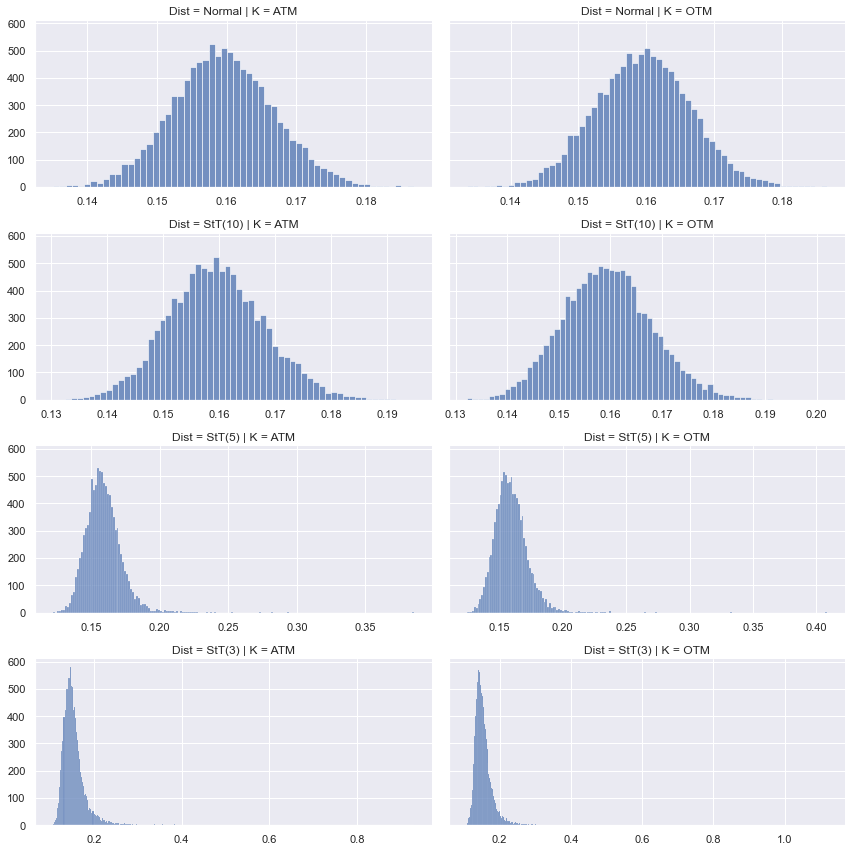

In [103]:
g_all = sns.FacetGrid(all_df, row='Dist', col='K', sharex=False, height=3, aspect=2);
g_all.map_dataframe(sns.histplot, x='realiz_vol');

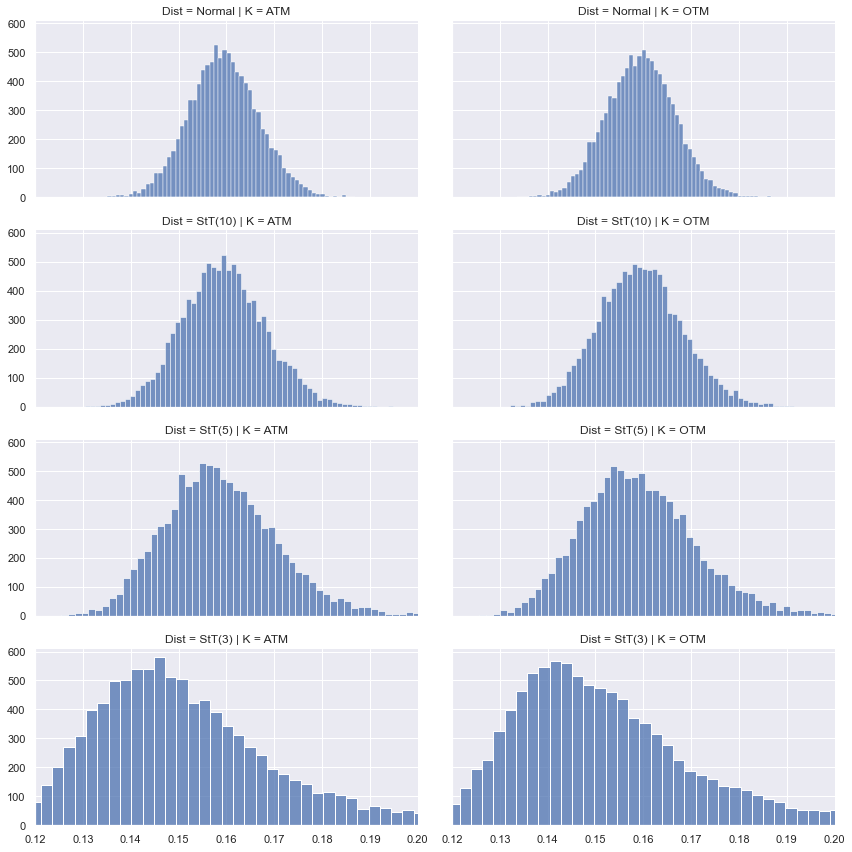

In [182]:
g_all = sns.FacetGrid(all_df, row='Dist', col='K', xlim=(0.12, 0.20), height=3, aspect=2);
g_all.map_dataframe(sns.histplot, x='realiz_vol');

### Option x Hedge

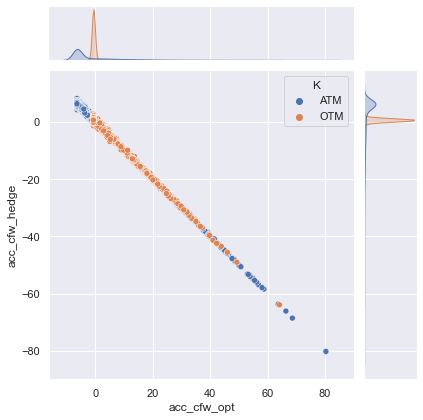

In [122]:
g = sns.jointplot(x='acc_cfw_opt', y='acc_cfw_hedge', hue='K', data=all_df[all_df['Dist']=='Normal'], height=6);

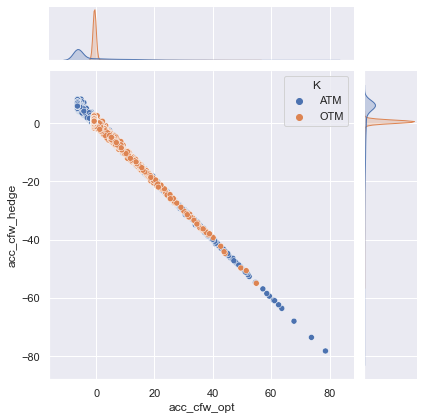

In [123]:
g = sns.jointplot(x='acc_cfw_opt', y='acc_cfw_hedge', hue='K', data=all_df[all_df['Dist']=='StT(10)'], height=6);

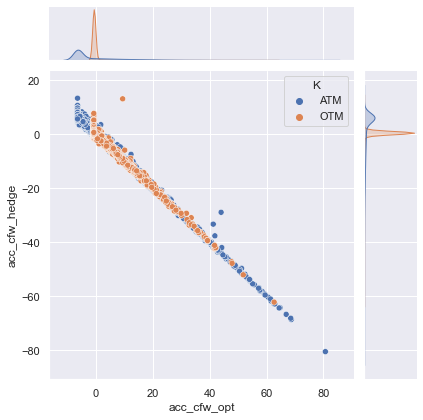

In [124]:
g = sns.jointplot(x='acc_cfw_opt', y='acc_cfw_hedge', hue='K', data=all_df[all_df['Dist']=='StT(5)'], height=6);

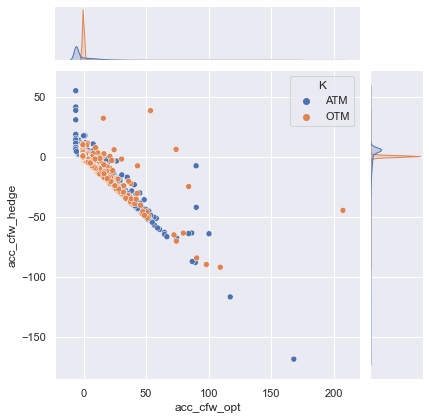

In [125]:
g = sns.jointplot(x='acc_cfw_opt', y='acc_cfw_hedge', hue='K', data=all_df[all_df['Dist']=='StT(3)'], height=6);

### Realized volatility of log-returns x Realized Cashflow

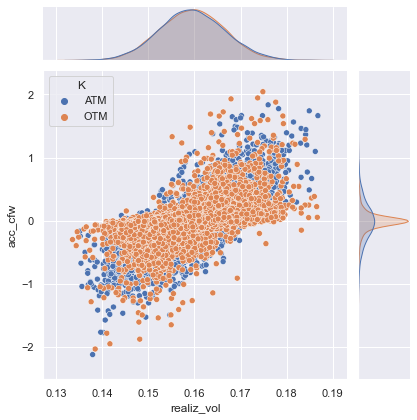

In [155]:
g = sns.jointplot(x='realiz_vol', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='Normal'], height=6);

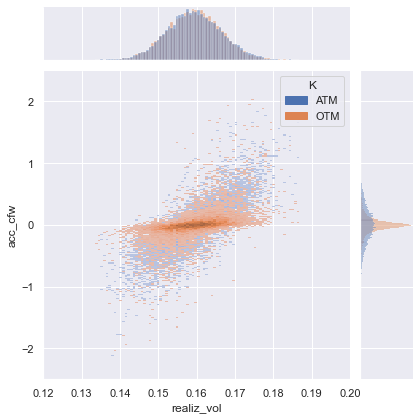

In [189]:
g = sns.jointplot(x='realiz_vol', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='Normal'], height=6,
                  xlim=(0.12, 0.20), ylim=(-2.5, +2.5));

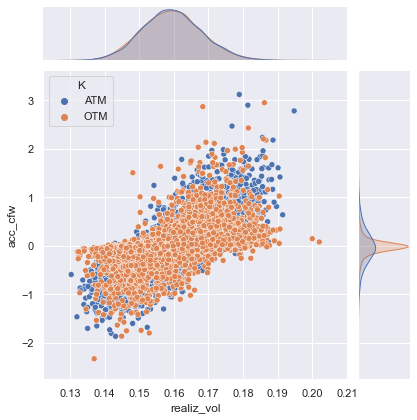

In [164]:
g = sns.jointplot(x='realiz_vol', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(10)'], height=6);

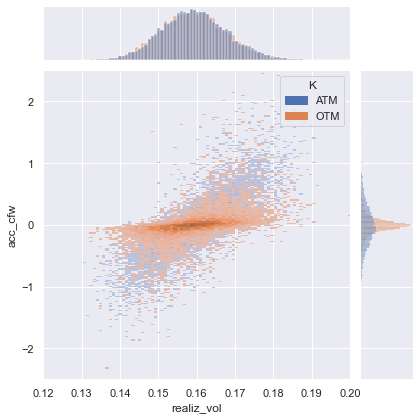

In [190]:
g = sns.jointplot(x='realiz_vol', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(10)'], height=6,
                  xlim=(0.12, 0.20), ylim=(-2.5, +2.5));

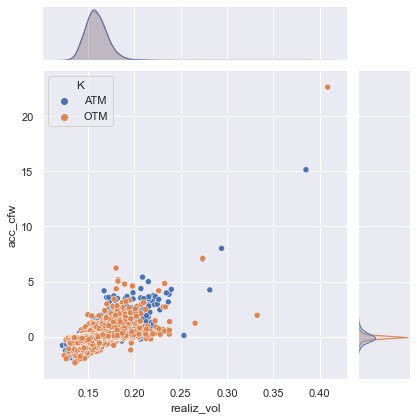

In [160]:
g = sns.jointplot(x='realiz_vol', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(5)'], height=6);

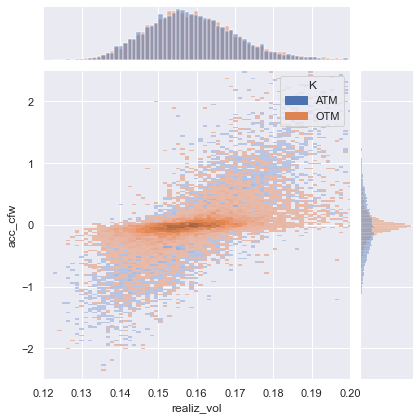

In [191]:
g = sns.jointplot(x='realiz_vol', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(5)'], height=6,
                  xlim=(0.12, 0.20), ylim=(-2.5, +2.5));

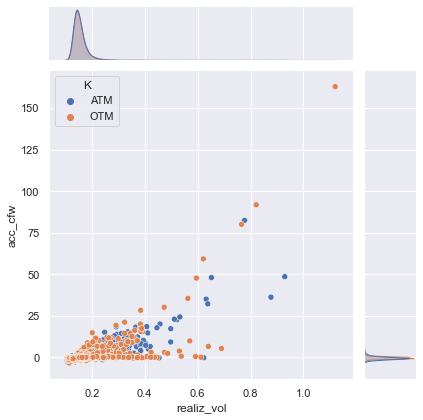

In [170]:
g = sns.jointplot(x='realiz_vol', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(3)'], height=6);

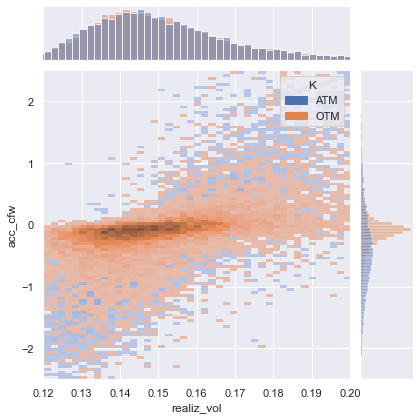

In [188]:
g = sns.jointplot(x='realiz_vol', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(3)'], height=6,
                  xlim=(0.12, 0.20), ylim=(-2.5, +2.5));

### Price at Maturity x Realized Cashflow

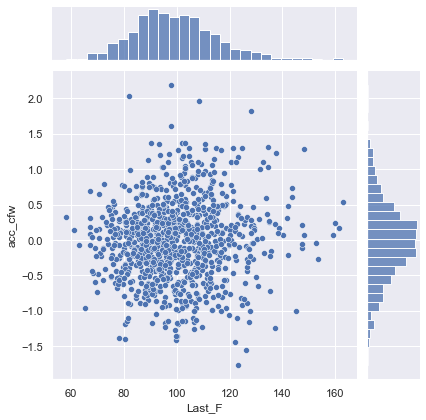

In [72]:
g = sns.jointplot(x='Last_F', y='acc_cfw', data=pnl_disp_df_Normal_IOTM, height=6);

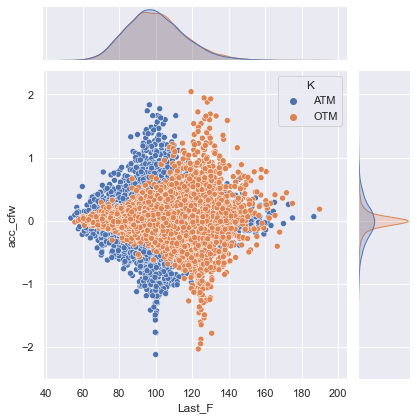

In [194]:
g = sns.jointplot(x='Last_F', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='Normal'], height=6);

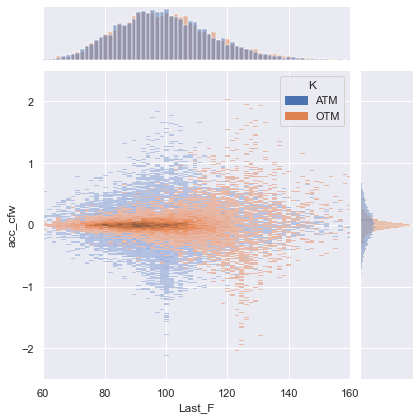

In [198]:
g = sns.jointplot(x='Last_F', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='Normal'], height=6,
                  xlim=(60, 160), ylim=(-2.5, +2.5));

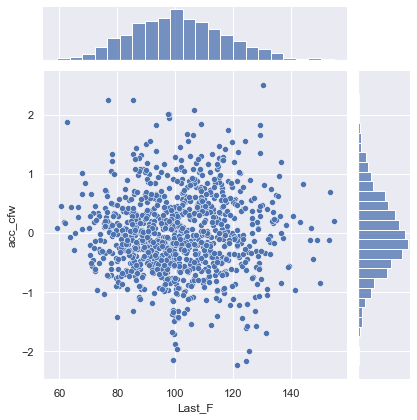

In [75]:
g = sns.jointplot(x='Last_F', y='acc_cfw', data=pnl_disp_df_10_IOTM, height=6);

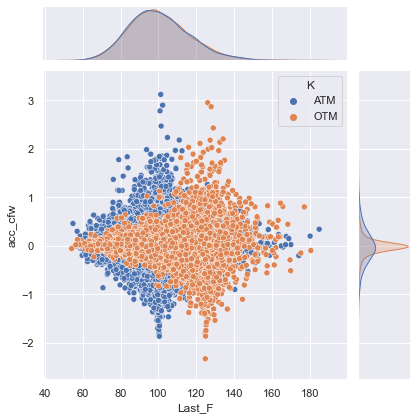

In [140]:
g = sns.jointplot(x='Last_F', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(10)'], height=6);

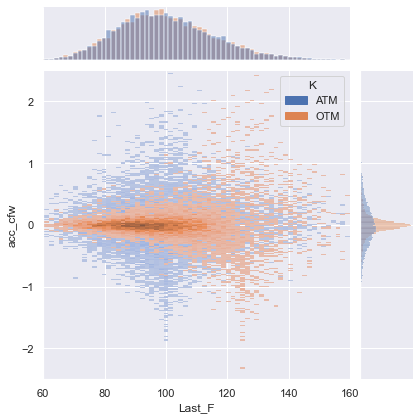

In [199]:
g = sns.jointplot(x='Last_F', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(10)'], height=6,
                  xlim=(60, 160), ylim=(-2.5, +2.5));

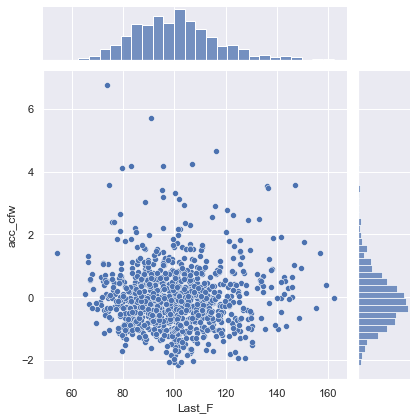

In [78]:
g = sns.jointplot(x='Last_F', y='acc_cfw', data=pnl_disp_df_5_IOTM, height=6);

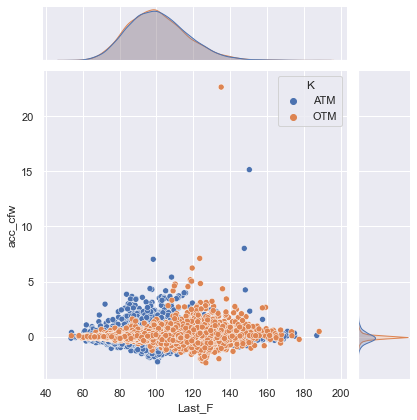

In [144]:
g = sns.jointplot(x='Last_F', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(5)'], height=6);

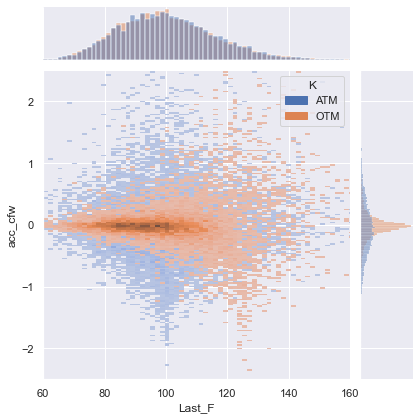

In [200]:
g = sns.jointplot(x='Last_F', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(5)'], height=6,
                  xlim=(60, 160), ylim=(-2.5, +2.5));

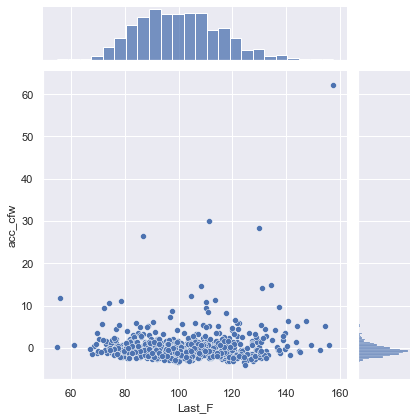

In [81]:
g = sns.jointplot(x='Last_F', y='acc_cfw', data=pnl_disp_df_3_IOTM, height=6);

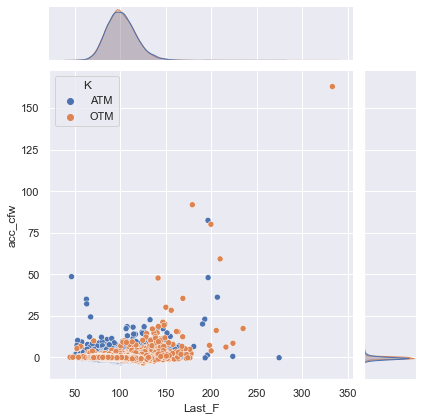

In [152]:
g = sns.jointplot(x='Last_F', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(3)'], height=6);

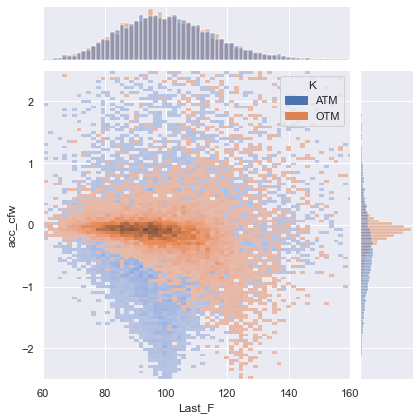

In [201]:
g = sns.jointplot(x='Last_F', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(3)'], height=6,
                  xlim=(60, 160), ylim=(-2.5, +2.5));

### Range Portfolio x Realized Cashflow

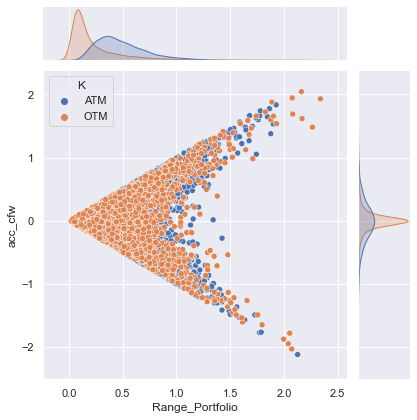

In [202]:
g = sns.jointplot(x='Range_Portfolio', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='Normal'], height=6);

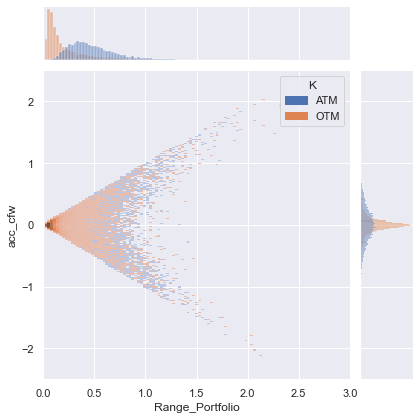

In [204]:
g = sns.jointplot(x='Range_Portfolio', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='Normal'], height=6,
                  xlim=(0, 3), ylim=(-2.5, +2.5));

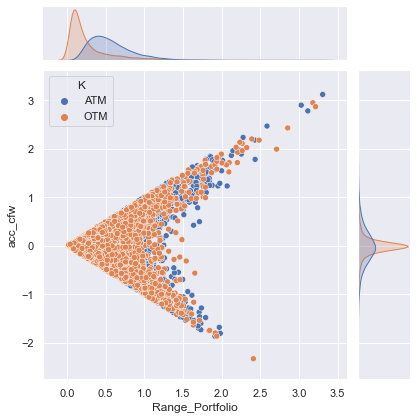

In [205]:
g = sns.jointplot(x='Range_Portfolio', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(10)'], height=6);

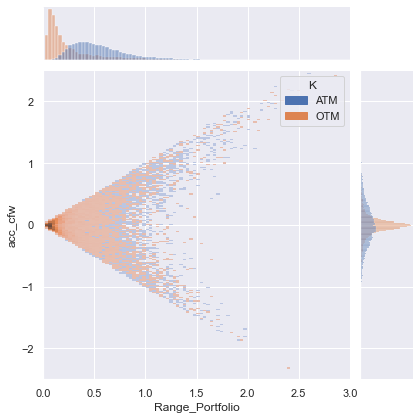

In [207]:
g = sns.jointplot(x='Range_Portfolio', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(10)'], height=6,
                  xlim=(0, 3), ylim=(-2.5, +2.5));

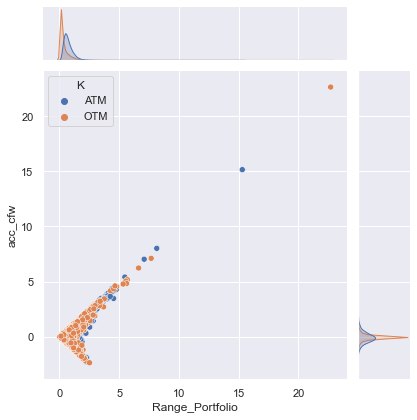

In [208]:
g = sns.jointplot(x='Range_Portfolio', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(5)'], height=6);

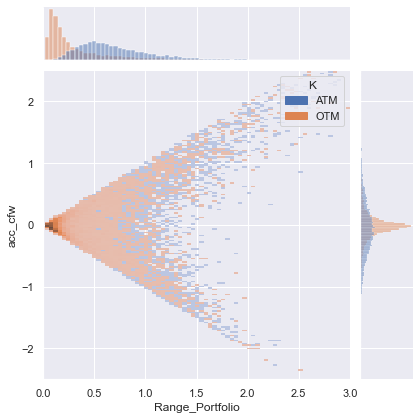

In [209]:
g = sns.jointplot(x='Range_Portfolio', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(5)'], height=6,
                  xlim=(0, 3), ylim=(-2.5, +2.5));

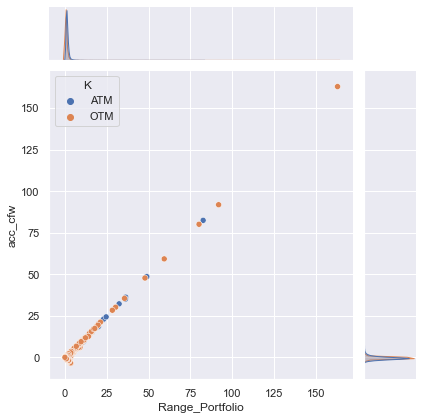

In [210]:
g = sns.jointplot(x='Range_Portfolio', y='acc_cfw', hue='K', data=all_df[all_df['Dist']=='StT(3)'], height=6);

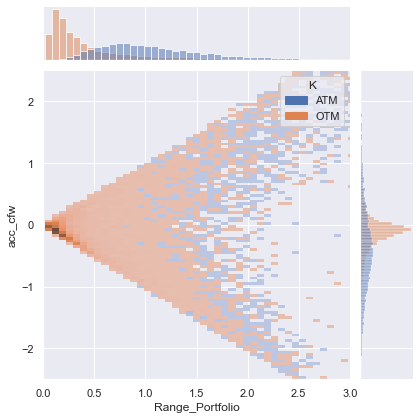

In [211]:
g = sns.jointplot(x='Range_Portfolio', y='acc_cfw', hue='K', kind='hist', data=all_df[all_df['Dist']=='StT(3)'], height=6,
                  xlim=(0, 3), ylim=(-2.5, +2.5));